In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
from multiprocessing import Process
import random
from feature_selection import feature_ranking_algorithm
import time

# ignore warnings
import warnings
warnings.filterwarnings("ignore")



## Load the data and EDA

In [2]:
original_data = pd.read_csv('RFLFSODataFull.csv')
original_data.head()

FSO_Att   RFL_Att  AbsoluteHumidity  AbsoluteHumidityMax  \
0  7.913289  6.927868         17.595709            17.615907   
1  7.451176  4.412096         17.549693            17.572415   
2  7.072747  6.268740         17.290230            17.644014   
3  6.949288  4.317853         16.820880            17.066776   
4  7.361052  6.114514         16.813820            17.953974   

   AbsoluteHumidityMin     Distance    Frequency  Particulate  ParticulateMax  \
0            17.340148  2115.338398  83500000000          0.0             0.0   
1            17.299439  2113.999257  73500000000          0.0             0.0   
2            16.037894  2118.689047  83500000000          0.0             0.0   
3            15.895622  2114.632339  73500000000          0.0             0.0   
4            15.227225  2116.786055  83500000000          0.0             0.0   

   ParticulateMin  ...  TemperatureMax  TemperatureMin  Time   Visibility  \
0             0.0  ...       26.603030       24.680849     9  65884.51846   
1             0.0  ...       26.377164       24.313108     9  64963.41092   
2             0.0  ...       27.670822       23.150277    10  54794.28107   
3             0.0  ...       26.522100       23.174815    10  50205.64159   
4             0.0  ...       26.305736       24.864100    10  59038.32599   

   VisibilityMax  VisibilityMin  WindDirection  WindSpeed  WindSpeedMax  \
0   72336.362233   65617.543754      88.755450   3.057066      6.863808   
1   68753.386153   60379.327485      99.790057   2.727910      6.468903   
2   54821.773817   50850.155963      65.730085   1.674810      2.826916   
3   52519.927530   45374.510898      88.127497   0.962068      2.780643   
4   64418.329138   54461.246506      84.167414   1.881007      4.476298   

   WindSpeedMin  
0      3.007939  
1      2.537393  
2      1.640809  
3      0.886951  
4      1.874052  

[5 rows x 27 columns]

In [3]:
original_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int64  
 15  Te

In [4]:
original_data.columns

Index(['FSO_Att', 'RFL_Att', 'AbsoluteHumidity', 'AbsoluteHumidityMax',
       'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate',
       'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax',
       'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature',
       'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time',
       'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection',
       'WindSpeed', 'WindSpeedMax', 'WindSpeedMin'],
      dtype='object')

In [5]:
original_data.shape

(91379, 27)

In [7]:
# show the count of each SYNOPCode
print(original_data['SYNOPCode'].value_counts())



SYNOPCode
0    56964
6    25018
5     6605
8     1716
4      466
7      419
3      191
Name: count, dtype: int64


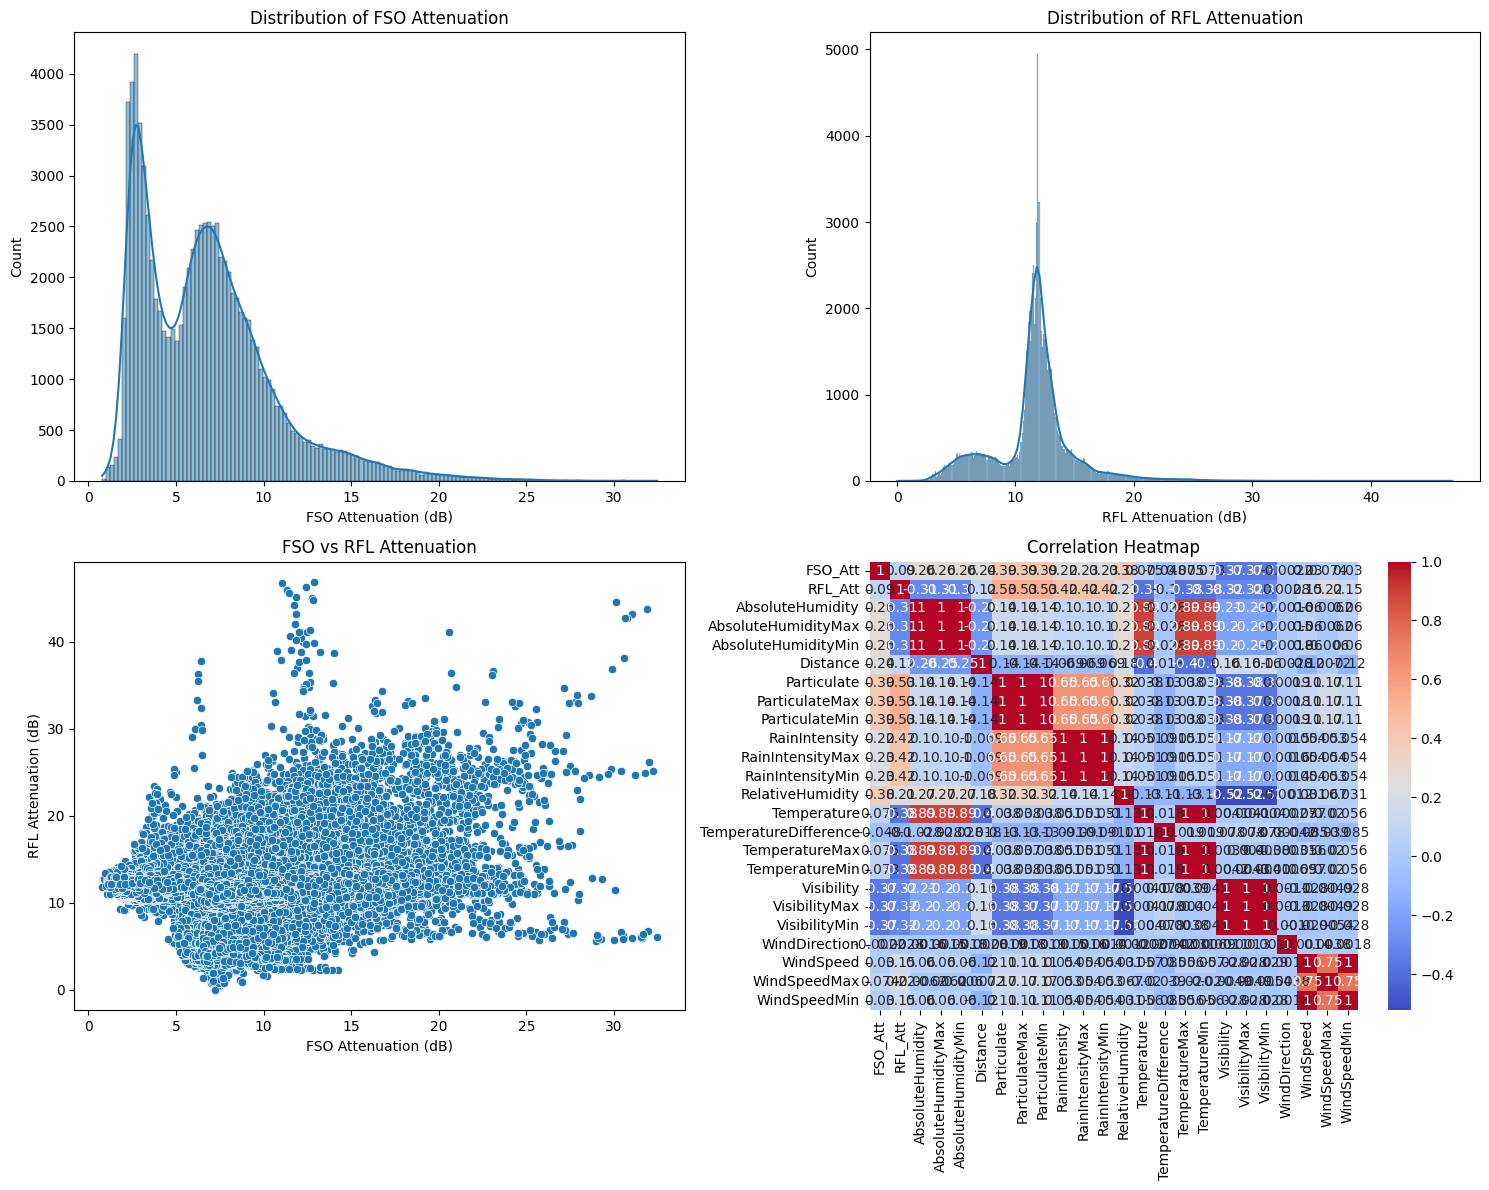

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.histplot(data=original_data, x='FSO_Att', kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of FSO Attenuation')
axes[0,0].set_xlabel('FSO Attenuation (dB)')


sns.histplot(data=original_data, x='RFL_Att', kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribution of RFL Attenuation')
axes[0,1].set_xlabel('RFL Attenuation (dB)')

# 2. FSO_Att vs RFL_Att scatter plot
sns.scatterplot(data=original_data, x='FSO_Att', y='RFL_Att', ax=axes[1,0])
axes[1,0].set_title('FSO vs RFL Attenuation')
axes[1,0].set_xlabel('FSO Attenuation (dB)')
axes[1,0].set_ylabel('RFL Attenuation (dB)')

# 3. Correlation Heatmap
# select the main numerical features
numerical_columns = original_data.select_dtypes(include=['float64']).columns
correlation = original_data[numerical_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()


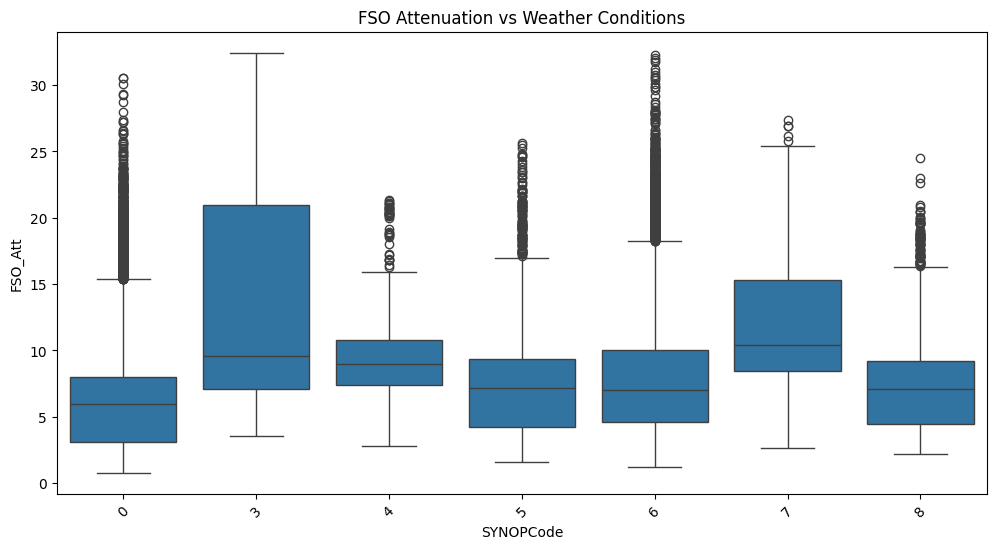

In [6]:
# boxplot to show the effect of weather conditions on attenuation
plt.figure(figsize=(12, 6))
sns.boxplot(data=original_data, x='SYNOPCode', y='FSO_Att')
plt.xticks(rotation=45)
plt.title('FSO Attenuation vs Weather Conditions')
plt.show()

In [6]:
print("column names:", original_data.columns.tolist())


column names: ['FSO_Att', 'RFL_Att', 'AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection', 'WindSpeed', 'WindSpeedMax', 'WindSpeedMin']


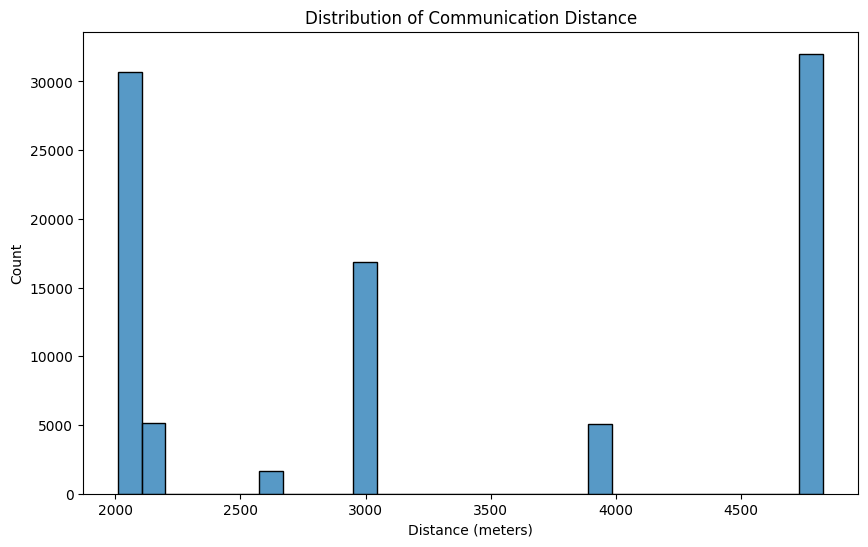

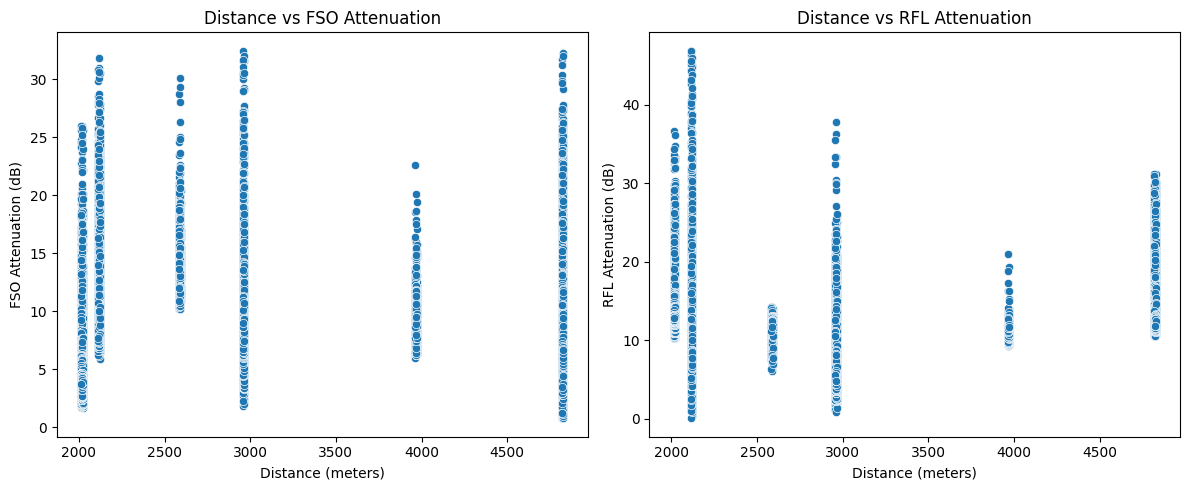

In [14]:
# distance distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(data=original_data, x='Distance', bins=30)
plt.title('Distribution of Communication Distance')
plt.xlabel('Distance (meters)')
plt.ylabel('Count')
plt.show()

# plot the relationship between Distance and attenuation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=original_data, x='Distance', y='FSO_Att')
plt.title('Distance vs FSO Attenuation')
plt.xlabel('Distance (meters)')
plt.ylabel('FSO Attenuation (dB)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=original_data, x='Distance', y='RFL_Att')
plt.title('Distance vs RFL Attenuation')
plt.xlabel('Distance (meters)')
plt.ylabel('RFL Attenuation (dB)')

plt.tight_layout()
plt.show()

In [7]:
print("\nunique values of Frequency:")
print(original_data['Frequency'].unique())

print("unique values of Time:")
print(original_data['Time'].unique())




unique values of Frequency:
[83500000000 73500000000]
unique values of Time:
[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3  4  5  6  7  8]


<Figure size 1200x1200 with 0 Axes>

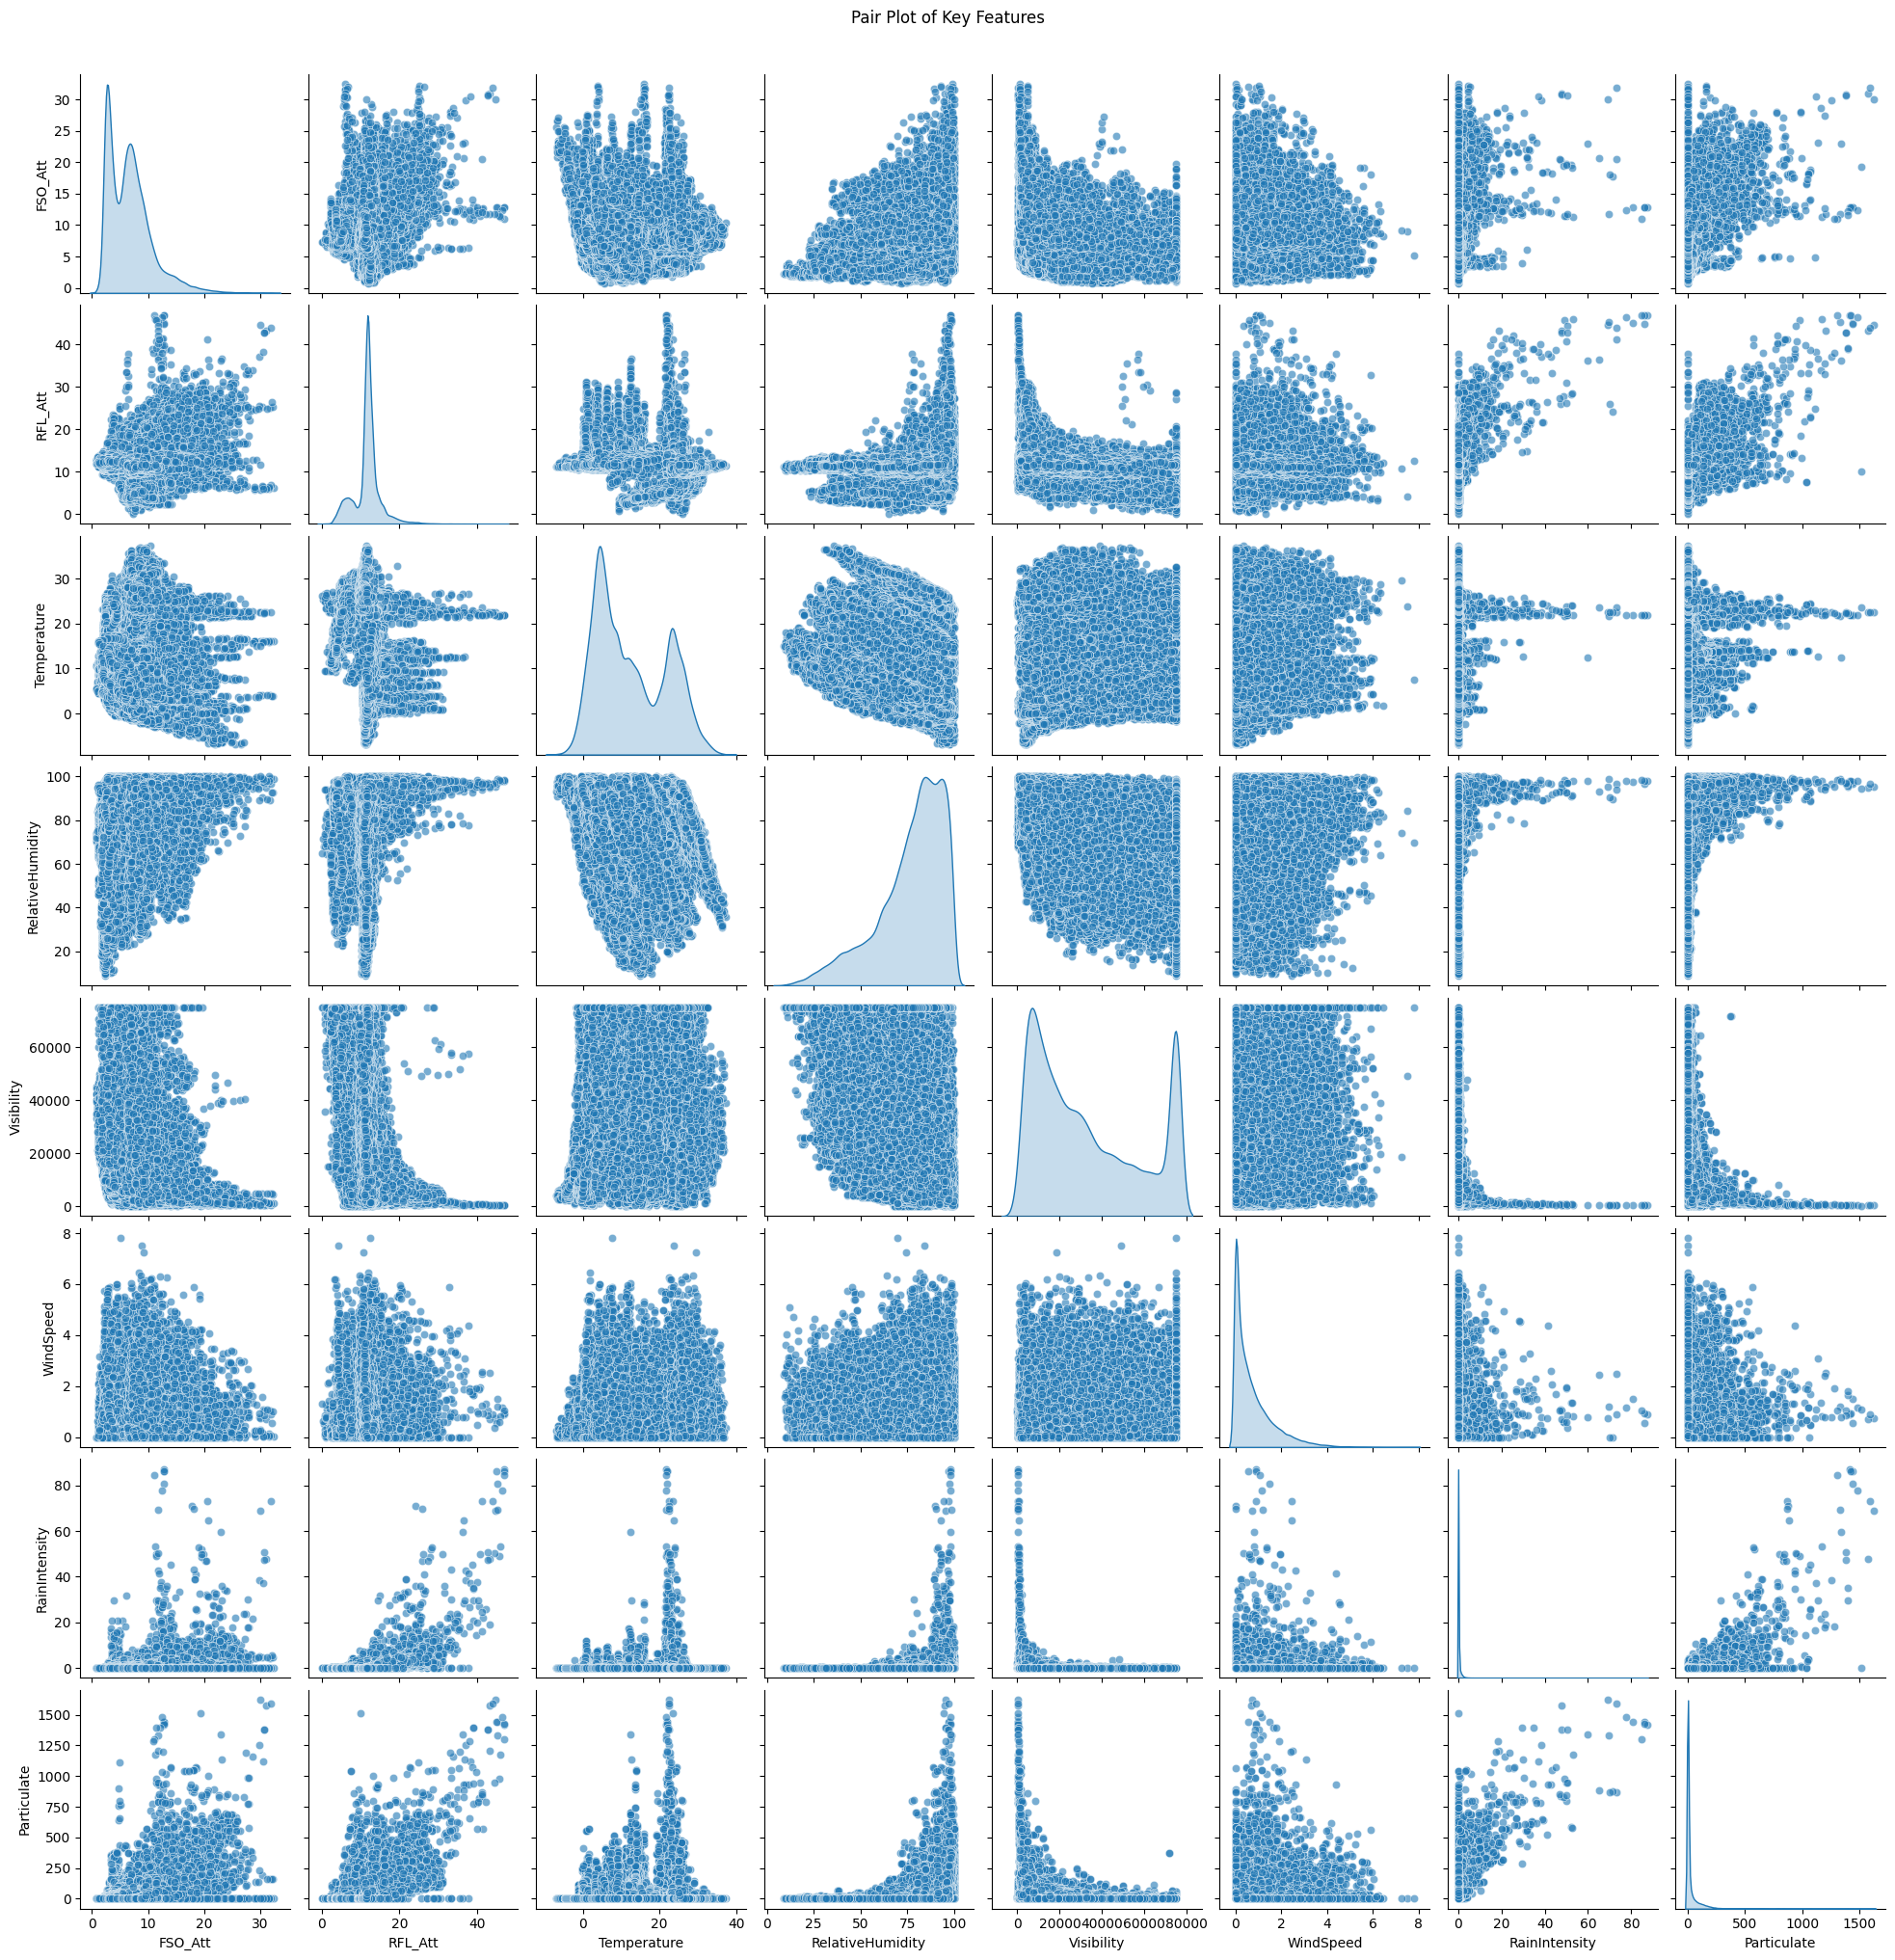

In [5]:
# select key variables
key_features = [
    'FSO_Att', 'RFL_Att', 
    'Temperature', 'RelativeHumidity',
    'Visibility', 'WindSpeed',
    'RainIntensity', 'Particulate'
]

# create pairplot
plt.figure(figsize=(12, 12))
sns.pairplot(
    data=original_data[key_features],
    diag_kind='kde',  
    plot_kws={'alpha': 0.6}, 
)
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()

In [15]:
# data preprocessing, mainly int type

#  6   Frequency              91379 non-null  int64  

#  14  SYNOPCode              91379 non-null  int64  

#  19  Time                   91379 non-null  int64  


processed_data = original_data.copy()

# Time: directly convert to category type
processed_data['Time'] = processed_data['Time'].astype('category')

# SYNOPCode: directly convert to category type
processed_data['SYNOPCode'] = processed_data['SYNOPCode'].astype('category')

# Frequency: convert to GHz unit
processed_data['Frequency'] = processed_data['Frequency'] / 1e9
print(processed_data.dtypes)


# prepare feature set (remove target variables)
feature_cols = [col for col in processed_data.columns 
               if col not in ['FSO_Att', 'RFL_Att']]
# X = processed_data[feature_cols]

FSO_Att                   float64
RFL_Att                   float64
AbsoluteHumidity          float64
AbsoluteHumidityMax       float64
AbsoluteHumidityMin       float64
Distance                  float64
Frequency                 float64
Particulate               float64
ParticulateMax            float64
ParticulateMin            float64
RainIntensity             float64
RainIntensityMax          float64
RainIntensityMin          float64
RelativeHumidity          float64
SYNOPCode                category
Temperature               float64
TemperatureDifference     float64
TemperatureMax            float64
TemperatureMin            float64
Time                     category
Visibility                float64
VisibilityMax             float64
VisibilityMin             float64
WindDirection             float64
WindSpeed                 float64
WindSpeedMax              float64
WindSpeedMin              float64
dtype: object


In [14]:
# save var to pickle
os.makedirs('data', exist_ok=True)


# use iloc to get the first 1000 rows data, for testing
processed_data_small = processed_data.iloc[0:1000]

with open('data/processed_data_head.pkl', 'wb') as f:
    pickle.dump(processed_data_small, f)


# processed_data
with open('data/processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)


# feature_cols
with open('data/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print("saved!")

saved!


## RFL

### Method 1

In [77]:
def plot_feature_selection_results(results_df, title, divide_feature, save_path=None):
    """
    plot the feature selection process
    
    Parameters:
    -----------
    results_df : DataFrame
        the dataframe containing the feature selection results
    title : str
        the title of the image
    save_path : str, optional
        if provided, save the image to the specified path
    """
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    # plot RMSE (blue line, left axis)
    line1 = ax1.plot(range(len(results_df)), 
                     results_df['oob_rmse'], 
                     color='blue', 
                     marker='o', 
                     label='RMSE')
    ax1.set_xlabel('Removed Features')
    ax1.set_ylabel('RMSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # plot R² (red line, right axis)
    line2 = ax2.plot(range(len(results_df)), 
                     results_df['oob_r2'], 
                     color='red', 
                     marker='o', 
                     label='R²')
    ax2.set_ylabel('R² Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')


    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels(results_df['removed_feature'], rotation=90, ha='center')

    # find the position of Time and add a vertical line
    time_idx = results_df[results_df['removed_feature'] == divide_feature].index[0]
    ax1.axvline(x=time_idx - 0.5,  # subtract 0.5 from x value !!
                color='green', 
                linestyle='--',
                linewidth=2,
                alpha=0.8,
                label='Time Position')

    lines = line1 + line2 + [ax1.get_lines()[-1]]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.title(title)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()





def load_and_plot_single_result(target_type, synop_code, divide_feature, method='method1'):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' 或 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'results_{target_type.lower()}'
    result_file = f'synop_{synop_code}_results.pkl'
    
    # load results
    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    
    # create image title
    title = f'Feature Selection Results for SYNOP {synop_code} ({target_type})'
    
    save_path = os.path.join(result_dir, f'{target_type.lower()}_{method}_{synop_code}.png')
    
    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide


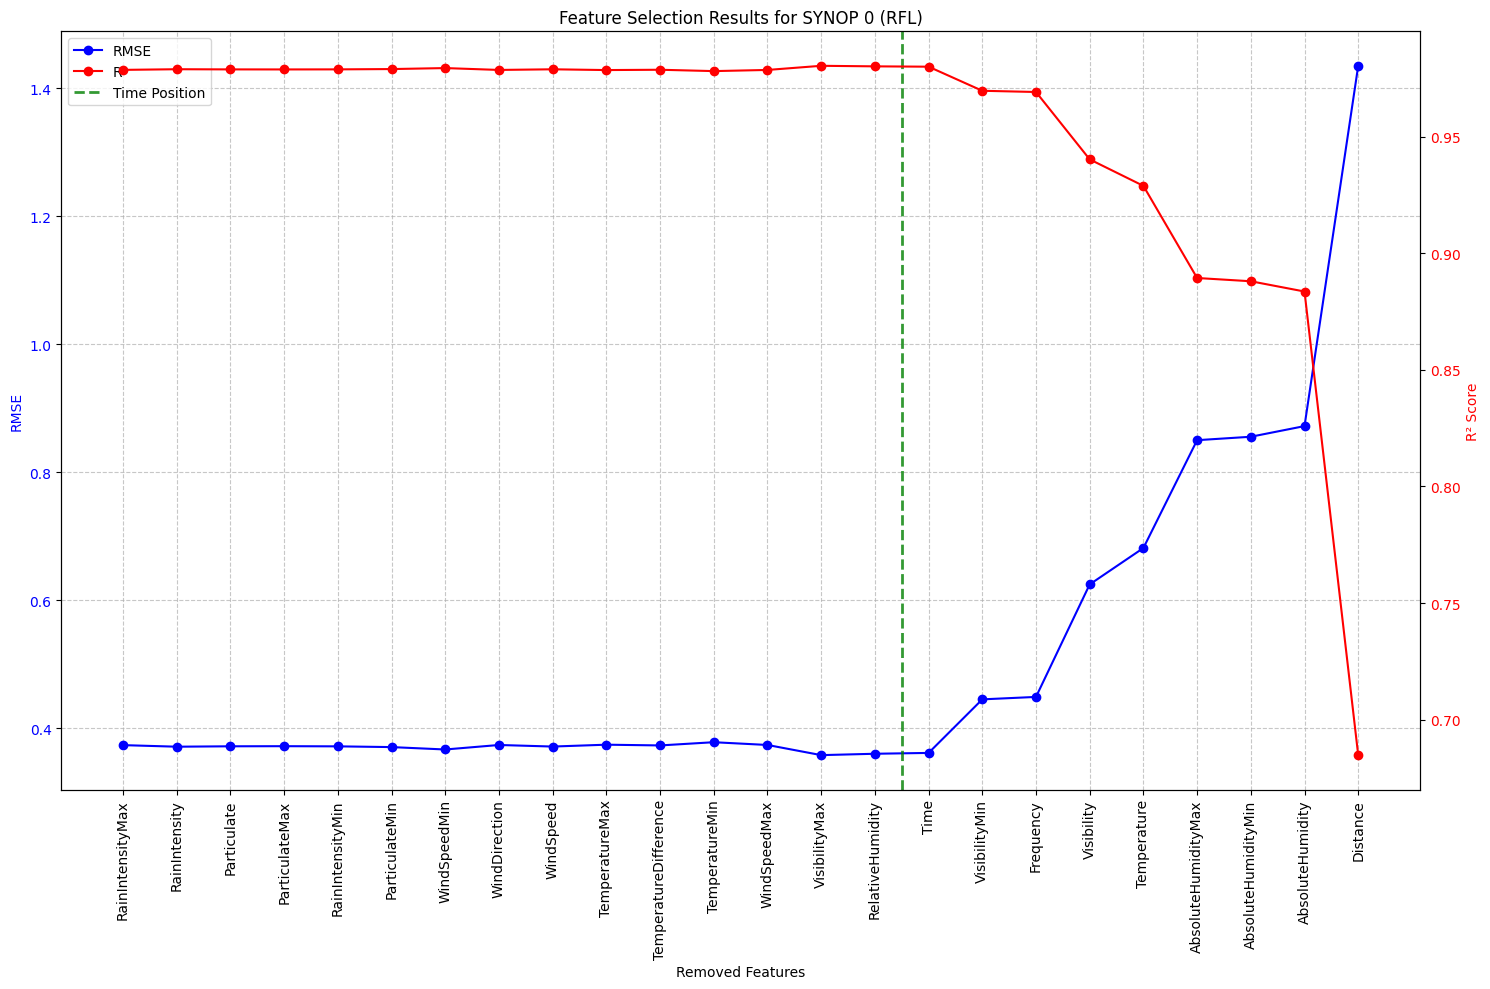

In [78]:
important_features_rfl_method1_synop_0 = load_and_plot_single_result('RFL', 0, 'Time')



In [28]:
important_features_rfl_method1_synop_0

['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'AbsoluteHumidityMin',
 'Distance',
 'Frequency',
 'Temperature',
 'Time',
 'Visibility',
 'VisibilityMin']

In [40]:
def gene_final_X_y(important_features, target_type, synop_code=None):
    if synop_code is None:
        # actually, method2
        group_data = processed_data
    else:
        # actually, method1
        group_data = processed_data[processed_data['SYNOPCode'] == synop_code]
    
    X = group_data[important_features]
    y = group_data[target_type]
    return X, y


def test_model(X, y):
    rf = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
    rf.fit(X, y)
    oob_predictions = rf.oob_prediction_
    oob_rmse = np.sqrt(mean_squared_error(y, oob_predictions))
    oob_r2 = r2_score(y, oob_predictions)
    return oob_rmse, oob_r2


In [57]:
X_rfl_method1_synop_0, y_rfl_method1_synop_0 = gene_final_X_y(important_features_rfl_method1_synop_0, 'RFL_Att', 0)
oob_rmse, oob_r2 = test_model(X_rfl_method1_synop_0, y_rfl_method1_synop_0)
print(f"\nOOB RMSE: {oob_rmse:.6f}")
print(f"OOB R² Score: {oob_r2:.6f}")


OOB RMSE: 0.361453
OOB R² Score: 0.980007


In [75]:
from sklearn.metrics import make_scorer
def tune_random_forest(X, y, param_grid=None, cv=5, verbose=True):
    """
    tune the hyperparameters of the random forest model
    
    Parameters:
    -----------
    X : feature data
    y : target variable
    param_grid : hyperparameter grid, if None, use the default grid
    cv : number of cross-validation folds
    verbose : whether to print detailed information
    
    Returns:
    --------
    dict : a dictionary containing the best model and performance metrics
    """
    # if param_grid is None, use the default grid
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 150],
            'max_depth': [None, 10, 20]
        }
    
    if verbose:
        print("Start tuning...")
        print(f"Dataset size: {X.shape}")
        print("Parameter grid:", param_grid)
        print("\n" + "-"*80)
        print(f"{'n_estimators':>12} | {'max_depth':>9} | {'OOB Score':>9} | {'OOB R²':>9} | {'OOB RMSE':>9}")
        print("-"*80)

    results = []


    # nested loop to iterate through all parameter combinations
    for n_trees in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            # train model
            rf = RandomForestRegressor(
                n_estimators=n_trees,
                max_depth=max_depth,
                random_state=42,
                oob_score=True,
                n_jobs=-1
            )
            rf.fit(X, y)
            
            # get OOB prediction and scores
            oob_score = rf.oob_score_
            y_pred = rf.oob_prediction_
            r2 = r2_score(y, y_pred)
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            
            results.append({
                'n_estimators': n_trees,
                'max_depth': max_depth,
                'oob_score': oob_score,
                'r2': r2,
                'rmse': rmse,
                'model': rf
            })
            
            if verbose:
                print(f"{n_trees:>12} | {str(max_depth):>9} | {oob_score:>9.6f} | {r2:>9.6f} | {rmse:>9.6f}")
    

    best_result = max(results, key=lambda x: x['oob_score'])

    if verbose:
        print("\nBest result:")
        print(f"Best parameters: n_estimators={best_result['n_estimators']}, max_depth={best_result['max_depth']}")
        print(f"Best OOB Score: {best_result['oob_score']:.6f}")
        print(f"Best OOB R² Score: {best_result['r2']:.6f}")
        print(f"Best OOB RMSE: {best_result['rmse']:.6f}")
    
    return {
        'best_params': {
            'n_estimators': best_result['n_estimators'],
            'max_depth': best_result['max_depth']
        },
        'best_oob_score': best_result['oob_score'],
        'final_model': best_result['model'],
        'oob_r2_score': best_result['r2'],
        'oob_rmse': best_result['rmse'],
        'results': results
    }



In [76]:

start_time = time.time()

rfl_method1_synop_0_tune = tune_random_forest(
    X_rfl_method1_synop_0, 
    y_rfl_method1_synop_0,
    cv=5,
    verbose=True
)

# get the final model
rfl_method1_synop_0_best_model = rfl_method1_synop_0_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")

Start tuning...
Dataset size: (56964, 9)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.980007 |  0.980007 |  0.361453
         100 |        10 |  0.963942 |  0.963942 |  0.485413
         100 |        20 |  0.980076 |  0.980076 |  0.360826
         150 |      None |  0.980077 |  0.980077 |  0.360817
         150 |        10 |  0.964439 |  0.964439 |  0.482057
         150 |        20 |  0.980005 |  0.980005 |  0.361471

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.980077
Best OOB R² Score: 0.980077
Best OOB RMSE: 0.360817
Model training time: 30.81 seconds


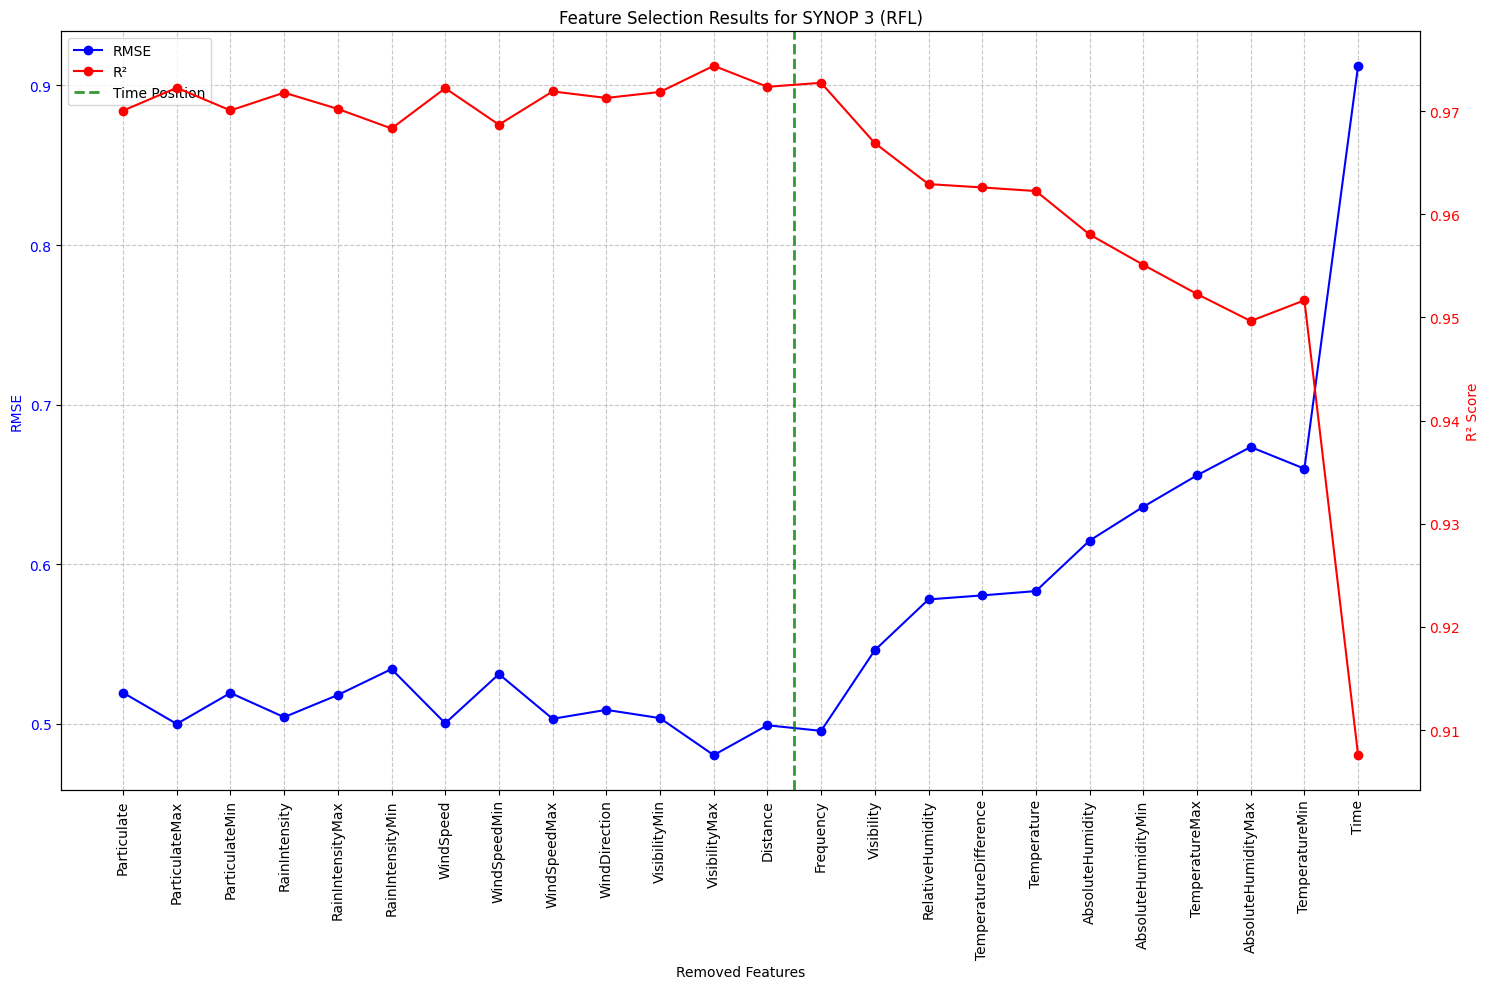

In [67]:
important_features_rfl_method1_synop_3 = load_and_plot_single_result('RFL', 3, 'Frequency')

In [34]:
important_features_rfl_method1_synop_3

['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'AbsoluteHumidityMin',
 'Frequency',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMax',
 'TemperatureMin',
 'Time',
 'Visibility']

In [78]:
X_rfl_method1_synop_3, y_rfl_method1_synop_3 = gene_final_X_y(important_features_rfl_method1_synop_3, 'RFL_Att', 3)


start_time = time.time()

rfl_method1_synop_3_tune = tune_random_forest(
    X_rfl_method1_synop_3, 
    y_rfl_method1_synop_3,
    cv=5,
    verbose=True
)

rfl_method1_synop_3_best_model = rfl_method1_synop_3_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")


Start tuning...
Dataset size: (191, 11)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.972743 |  0.972743 |  0.495451
         100 |        10 |  0.972990 |  0.972990 |  0.493201
         100 |        20 |  0.972743 |  0.972743 |  0.495451
         150 |      None |  0.972718 |  0.972718 |  0.495672
         150 |        10 |  0.972928 |  0.972928 |  0.493764
         150 |        20 |  0.972718 |  0.972718 |  0.495672

Best result:
Best parameters: n_estimators=100, max_depth=10
Best OOB Score: 0.972990
Best OOB R² Score: 0.972990
Best OOB RMSE: 0.493201
Model training time: 1.00 seconds


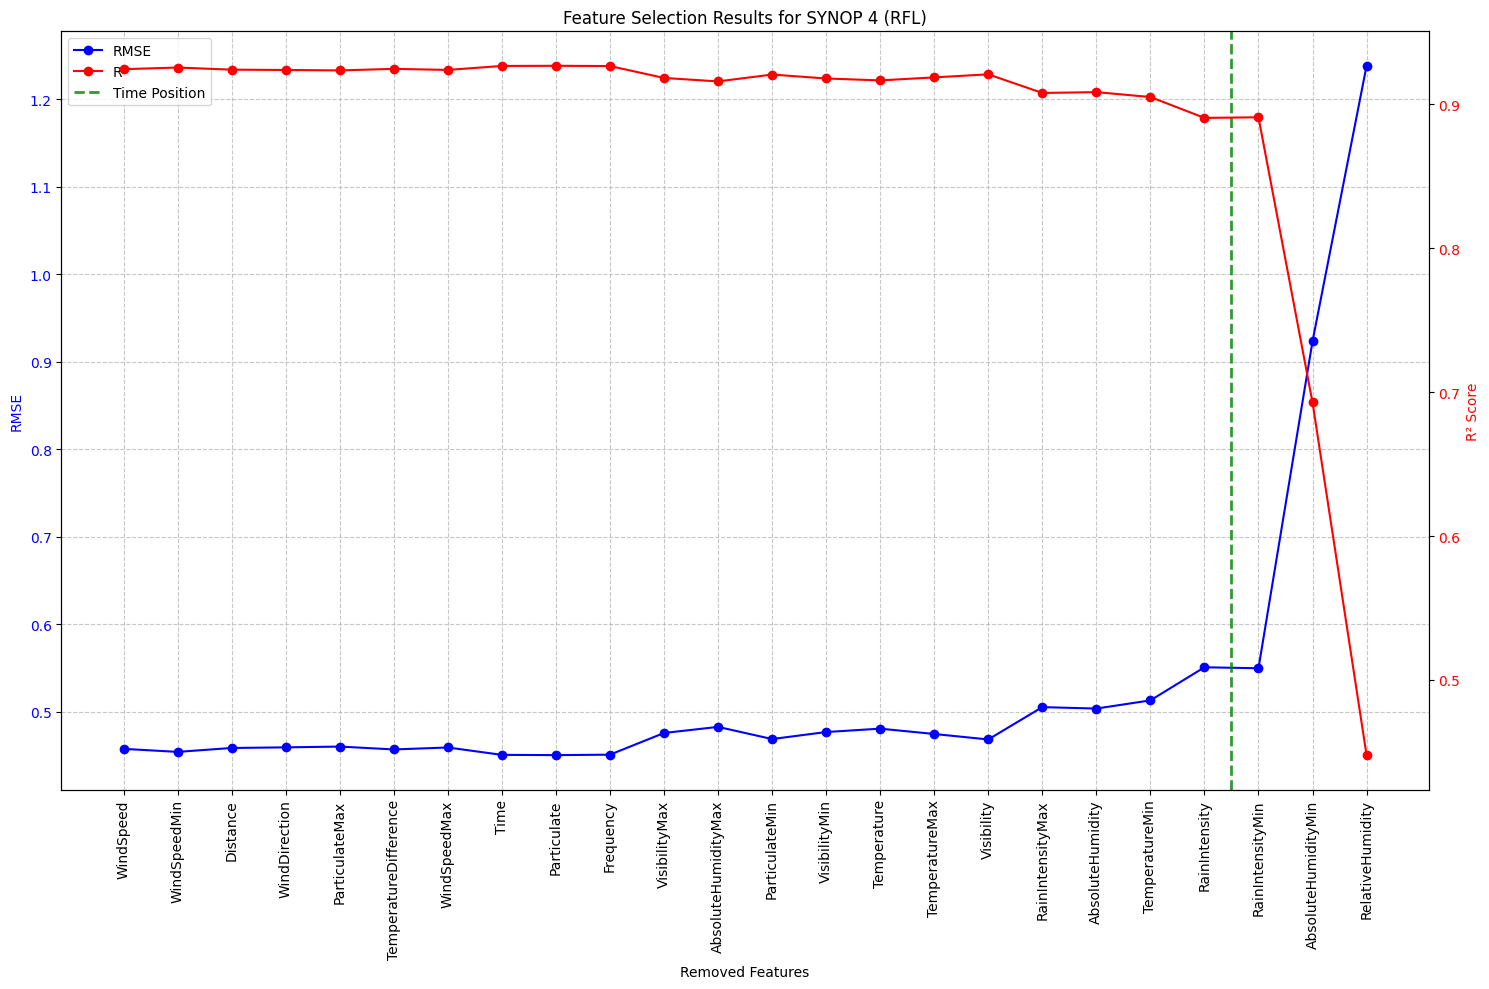

In [68]:
important_features_rfl_method1_synop_4 = load_and_plot_single_result('RFL', 4, 'RainIntensityMin')

In [36]:
important_features_rfl_method1_synop_4

['AbsoluteHumidityMin', 'RainIntensityMin', 'RelativeHumidity']

In [81]:

X_rfl_method1_synop_4, y_rfl_method1_synop_4 = gene_final_X_y(important_features_rfl_method1_synop_4, 'RFL_Att', 4)

start_time = time.time()

rfl_method1_synop_4_tune = tune_random_forest(
    X_rfl_method1_synop_4, 
    y_rfl_method1_synop_4,
    cv=5,
    verbose=True
)

rfl_method1_synop_4_best_model = rfl_method1_synop_4_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (466, 3)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.891109 |  0.891109 |  0.549894
         100 |        10 |  0.891223 |  0.891223 |  0.549607
         100 |        20 |  0.891080 |  0.891080 |  0.549968
         150 |      None |  0.891233 |  0.891233 |  0.549582
         150 |        10 |  0.891035 |  0.891035 |  0.550082
         150 |        20 |  0.891324 |  0.891324 |  0.549351

Best result:
Best parameters: n_estimators=150, max_depth=20
Best OOB Score: 0.891324
Best OOB R² Score: 0.891324
Best OOB RMSE: 0.549351
Model training time: 0.79 seconds


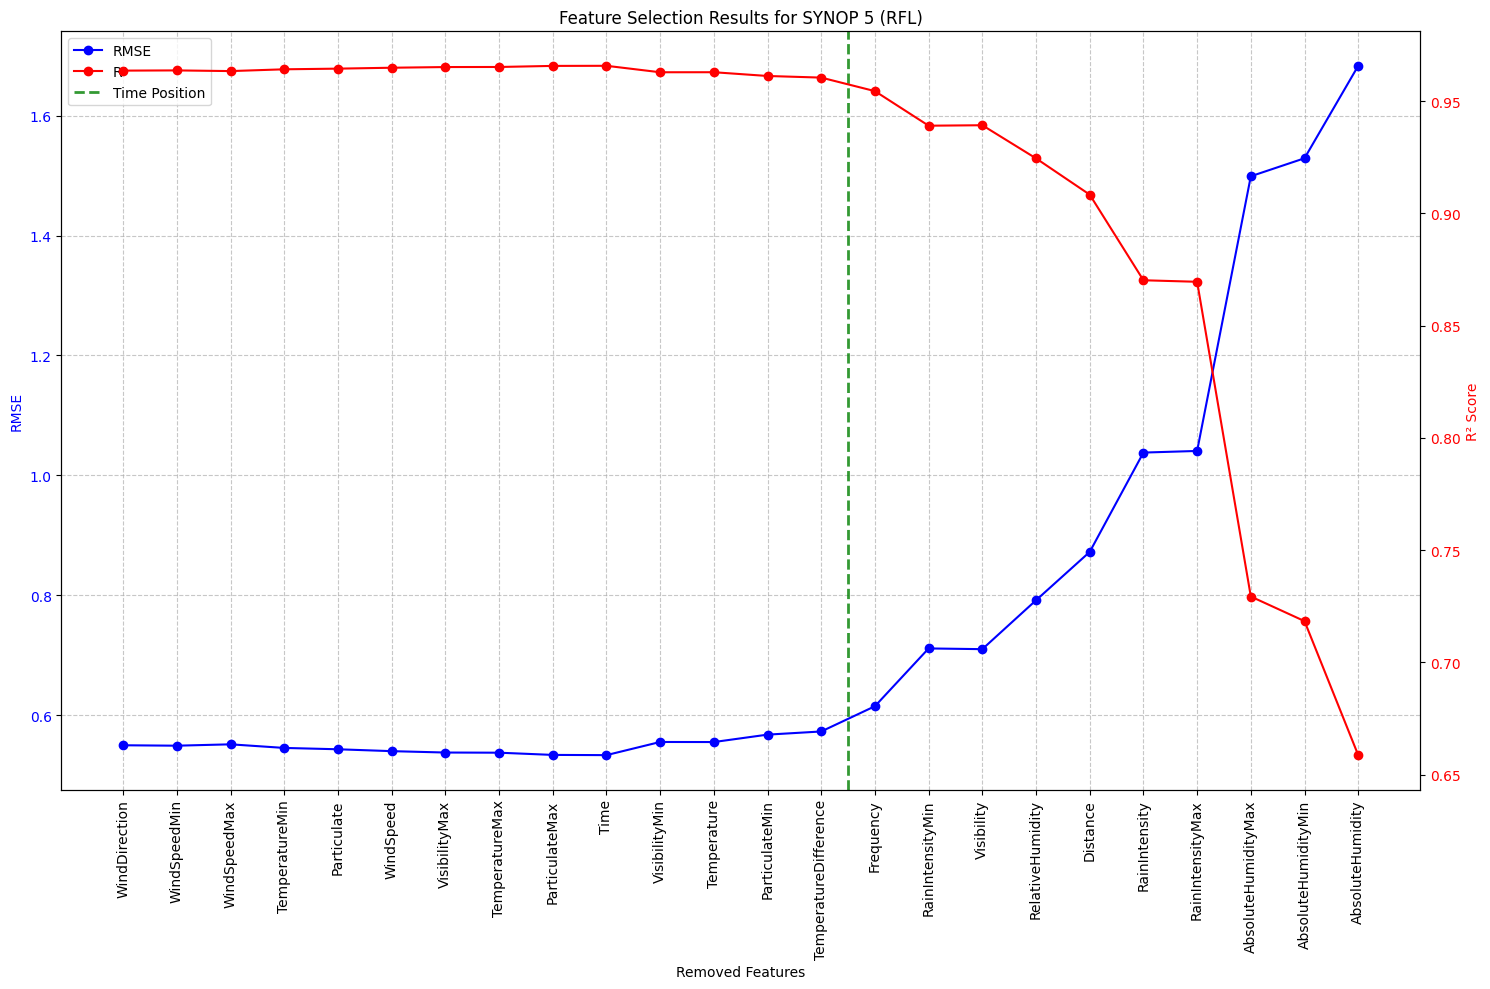

In [69]:
important_features_rfl_method1_synop_5 = load_and_plot_single_result('RFL', 5, 'Frequency')

In [41]:
important_features_rfl_method1_synop_5

['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'AbsoluteHumidityMin',
 'Distance',
 'Frequency',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'Visibility']

In [83]:

X_rfl_method1_synop_5, y_rfl_method1_synop_5 = gene_final_X_y(important_features_rfl_method1_synop_5, 'RFL_Att', 5)

start_time = time.time()

rfl_method1_synop_5_tune = tune_random_forest(
    X_rfl_method1_synop_5, 
    y_rfl_method1_synop_5,
    cv=5,
    verbose=True
)

rfl_method1_synop_5_best_model = rfl_method1_synop_5_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (6605, 10)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.954467 |  0.954467 |  0.614751
         100 |        10 |  0.948893 |  0.948893 |  0.651295
         100 |        20 |  0.954394 |  0.954394 |  0.615244
         150 |      None |  0.955075 |  0.955075 |  0.610630
         150 |        10 |  0.949202 |  0.949202 |  0.649323
         150 |        20 |  0.955031 |  0.955031 |  0.610932

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.955075
Best OOB R² Score: 0.955075
Best OOB RMSE: 0.610630
Model training time: 3.10 seconds


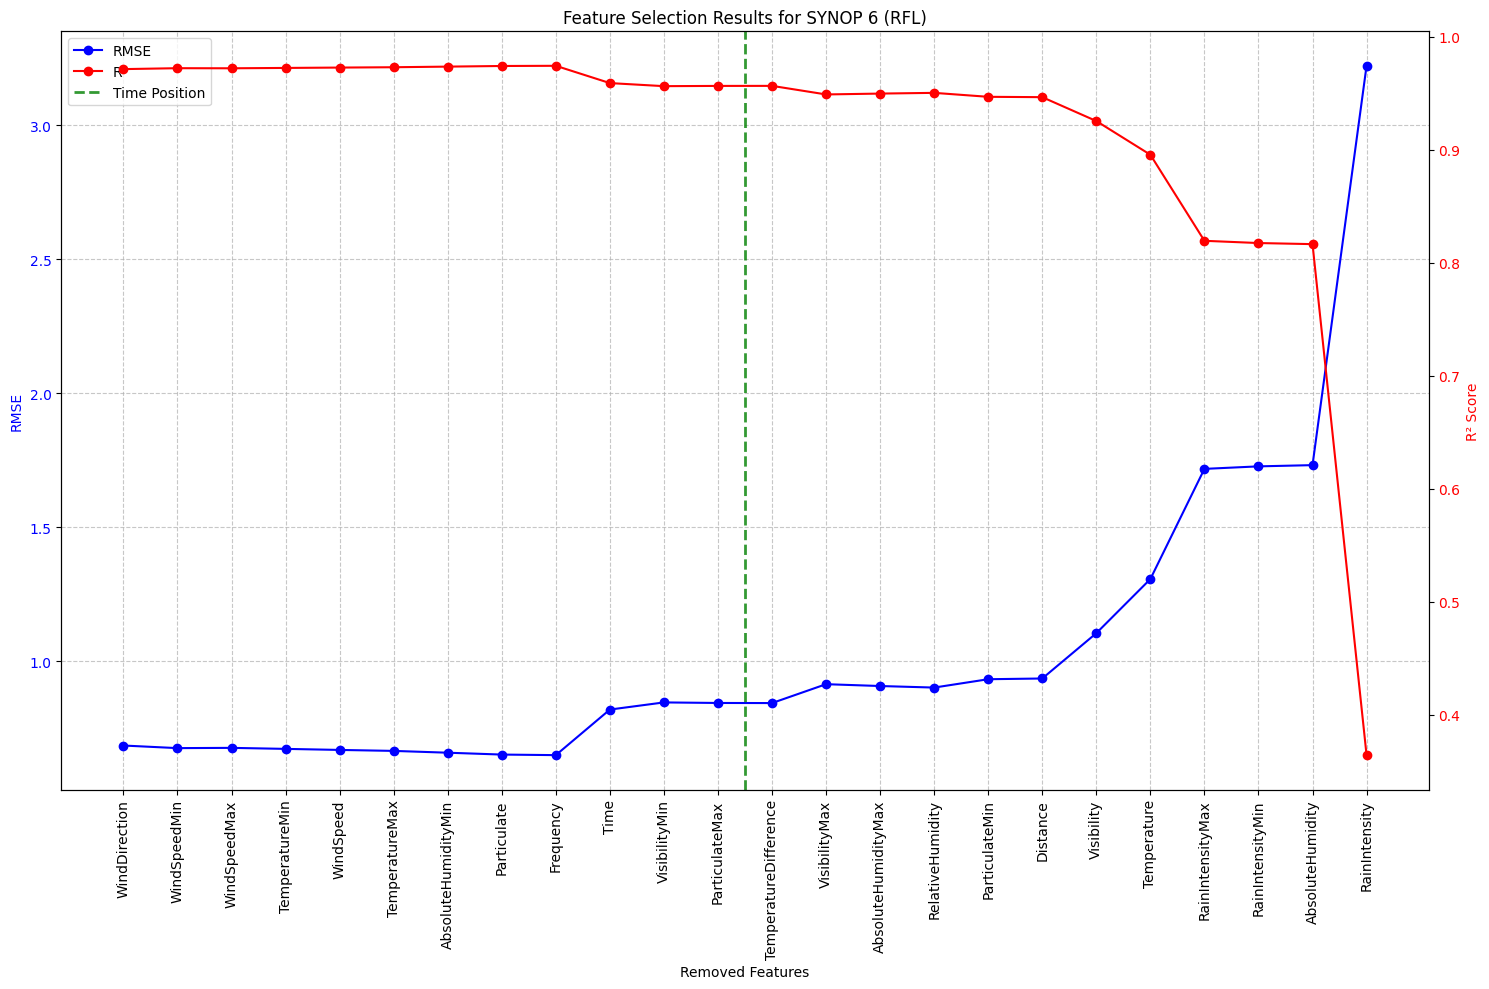

In [70]:
important_features_rfl_method1_synop_6 = load_and_plot_single_result('RFL', 6, 'TemperatureDifference')

In [45]:
important_features_rfl_method1_synop_6

['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'Distance',
 'ParticulateMin',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'Visibility',
 'VisibilityMax']

In [85]:

X_rfl_method1_synop_6, y_rfl_method1_synop_6 = gene_final_X_y(important_features_rfl_method1_synop_6, 'RFL_Att', 6)

start_time = time.time()

rfl_method1_synop_6_tune = tune_random_forest(
    X_rfl_method1_synop_6, 
    y_rfl_method1_synop_6,
    cv=5,
    verbose=True
)

rfl_method1_synop_6_best_model = rfl_method1_synop_6_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (25018, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.956430 |  0.956430 |  0.843669
         100 |        10 |  0.945941 |  0.945941 |  0.939743
         100 |        20 |  0.956376 |  0.956376 |  0.844187
         150 |      None |  0.957086 |  0.957086 |  0.837292
         150 |        10 |  0.946484 |  0.946484 |  0.935018
         150 |        20 |  0.957057 |  0.957057 |  0.837572

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.957086
Best OOB R² Score: 0.957086
Best OOB RMSE: 0.837292
Model training time: 16.99 seconds


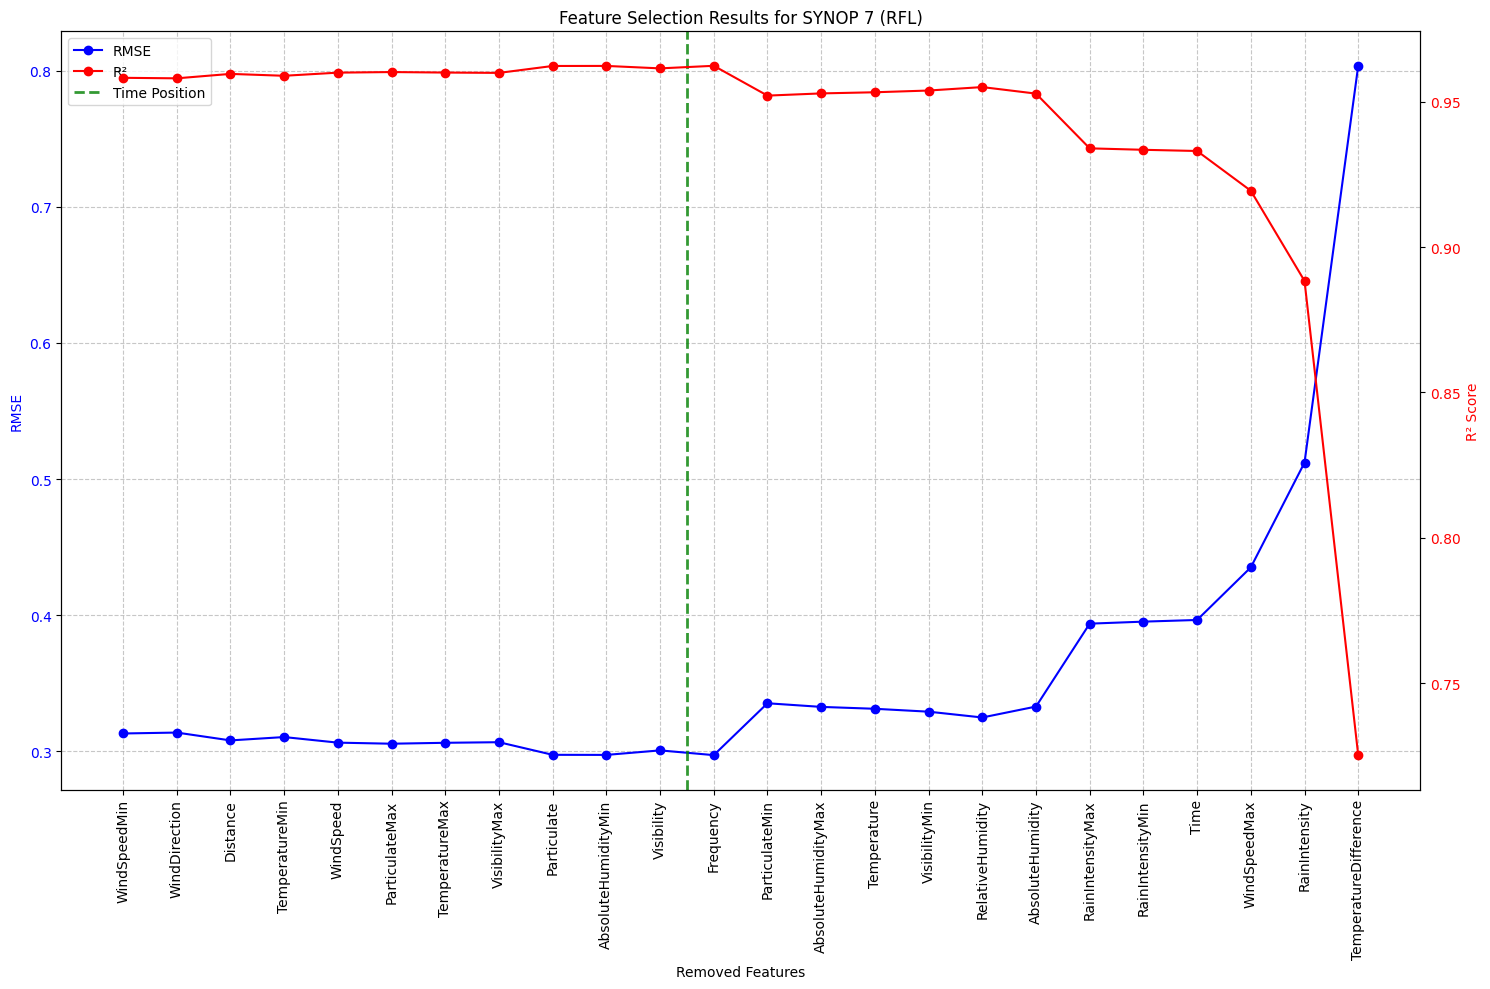

In [71]:
important_features_rfl_method1_synop_7 = load_and_plot_single_result('RFL', 7, 'Frequency')

In [57]:
important_features_rfl_method1_synop_7

['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'Frequency',
 'ParticulateMin',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'Time',
 'VisibilityMin',
 'WindSpeedMax']

In [87]:

X_rfl_method1_synop_7, y_rfl_method1_synop_7 = gene_final_X_y(important_features_rfl_method1_synop_7, 'RFL_Att', 7)

start_time = time.time()

rfl_method1_synop_7_tune = tune_random_forest(
    X_rfl_method1_synop_7, 
    y_rfl_method1_synop_7,
    cv=5,
    verbose=True
)

rfl_method1_synop_7_best_model = rfl_method1_synop_7_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (419, 13)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.962382 |  0.962382 |  0.297314
         100 |        10 |  0.961831 |  0.961831 |  0.299482
         100 |        20 |  0.962398 |  0.962398 |  0.297250
         150 |      None |  0.960330 |  0.960330 |  0.305312
         150 |        10 |  0.959971 |  0.959971 |  0.306693
         150 |        20 |  0.960390 |  0.960390 |  0.305084

Best result:
Best parameters: n_estimators=100, max_depth=20
Best OOB Score: 0.962398
Best OOB R² Score: 0.962398
Best OOB RMSE: 0.297250
Model training time: 0.90 seconds


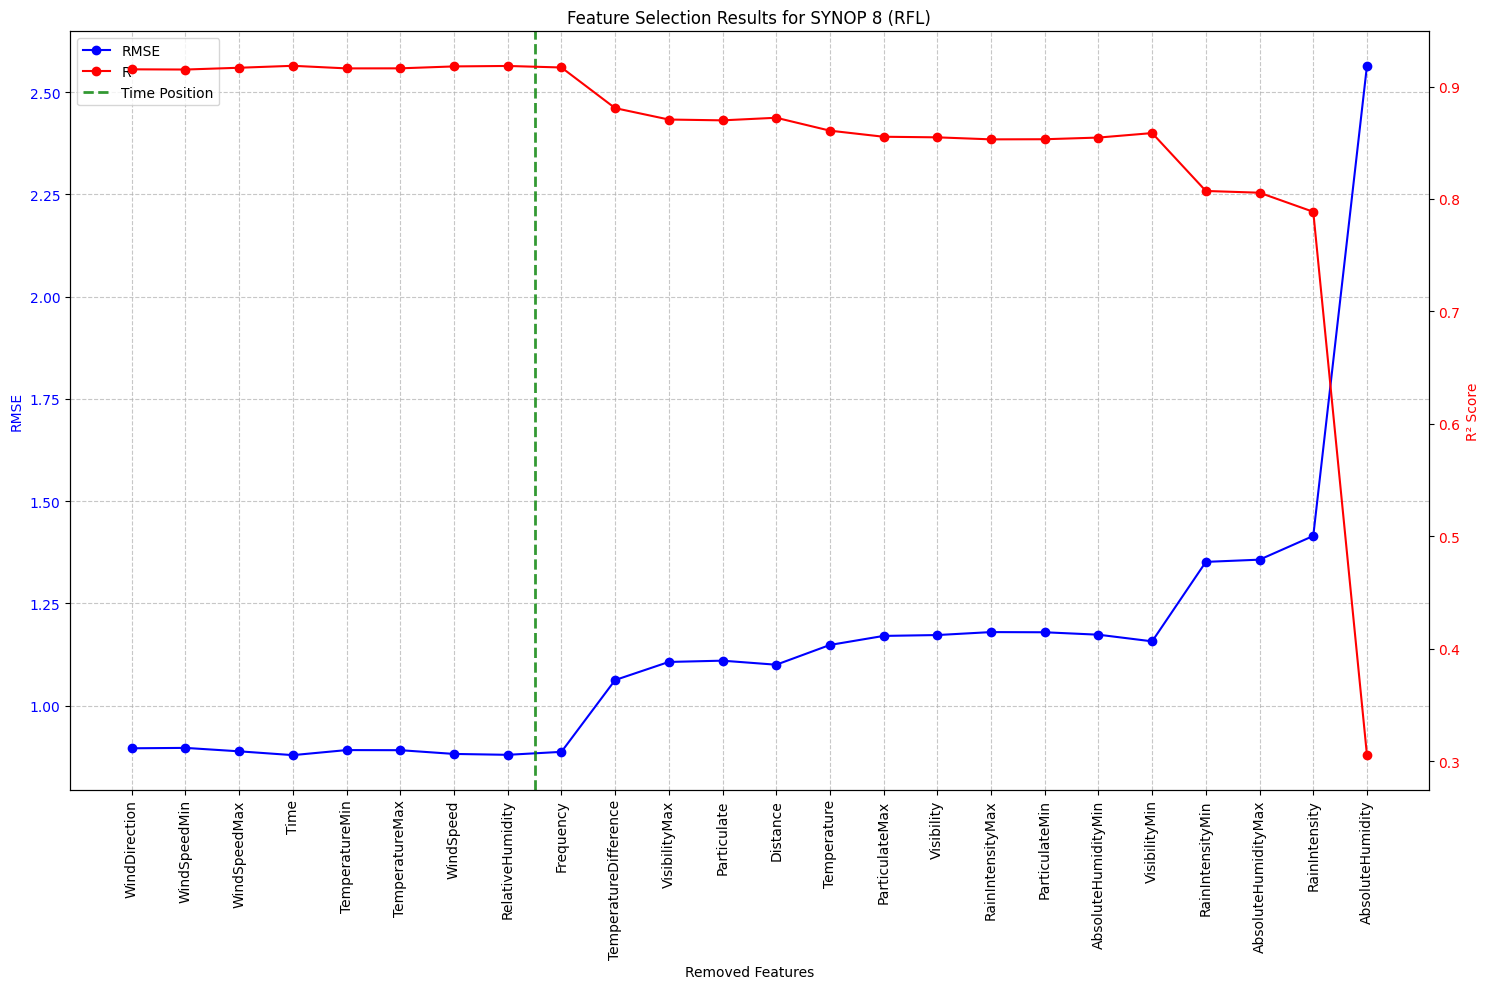

In [72]:
important_features_rfl_method1_synop_8 = load_and_plot_single_result('RFL', 8, 'Frequency')


In [59]:
important_features_rfl_method1_synop_8

['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'AbsoluteHumidityMin',
 'Distance',
 'Frequency',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'Temperature',
 'TemperatureDifference',
 'Visibility',
 'VisibilityMax',
 'VisibilityMin']

In [90]:

X_rfl_method1_synop_8, y_rfl_method1_synop_8 = gene_final_X_y(important_features_rfl_method1_synop_8, 'RFL_Att', 8)

start_time = time.time()

rfl_method1_synop_8_tune = tune_random_forest(
    X_rfl_method1_synop_8, 
    y_rfl_method1_synop_8,
    cv=5,
    verbose=True
)

rfl_method1_synop_8_best_model = rfl_method1_synop_8_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (1716, 16)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.916933 |  0.916933 |  0.886692
         100 |        10 |  0.911067 |  0.911067 |  0.917469
         100 |        20 |  0.916099 |  0.916099 |  0.891134
         150 |      None |  0.915802 |  0.915802 |  0.892709
         150 |        10 |  0.911842 |  0.911842 |  0.913458
         150 |        20 |  0.915934 |  0.915934 |  0.892009

Best result:
Best parameters: n_estimators=100, max_depth=None
Best OOB Score: 0.916933
Best OOB R² Score: 0.916933
Best OOB RMSE: 0.886692
Model training time: 1.57 seconds


### Method 2

In [83]:
def load_and_plot_method2_result(target_type, divide_feature):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' or 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'method2'
    result_file = f'results_{target_type.lower()}_method2.pkl'
    

    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    

    title = f'Feature Selection Results for {target_type} Method 2 ({divide_feature})'
    

    save_path = os.path.join(result_dir, f'{target_type}_method2_plot.png')
    

    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide


In [8]:
X_rfl_method2 = processed_data[feature_cols]
y_rfl_method2 = processed_data['RFL_Att']

results_rfl_method2 = feature_ranking_algorithm(X_rfl_method2, y_rfl_method2, n_jobs=-1)
# save results_rfl_method2 to pickle
with open('method2/results_rfl_method2.pkl', 'wb') as f:
    pickle.dump(results_rfl_method2, f)

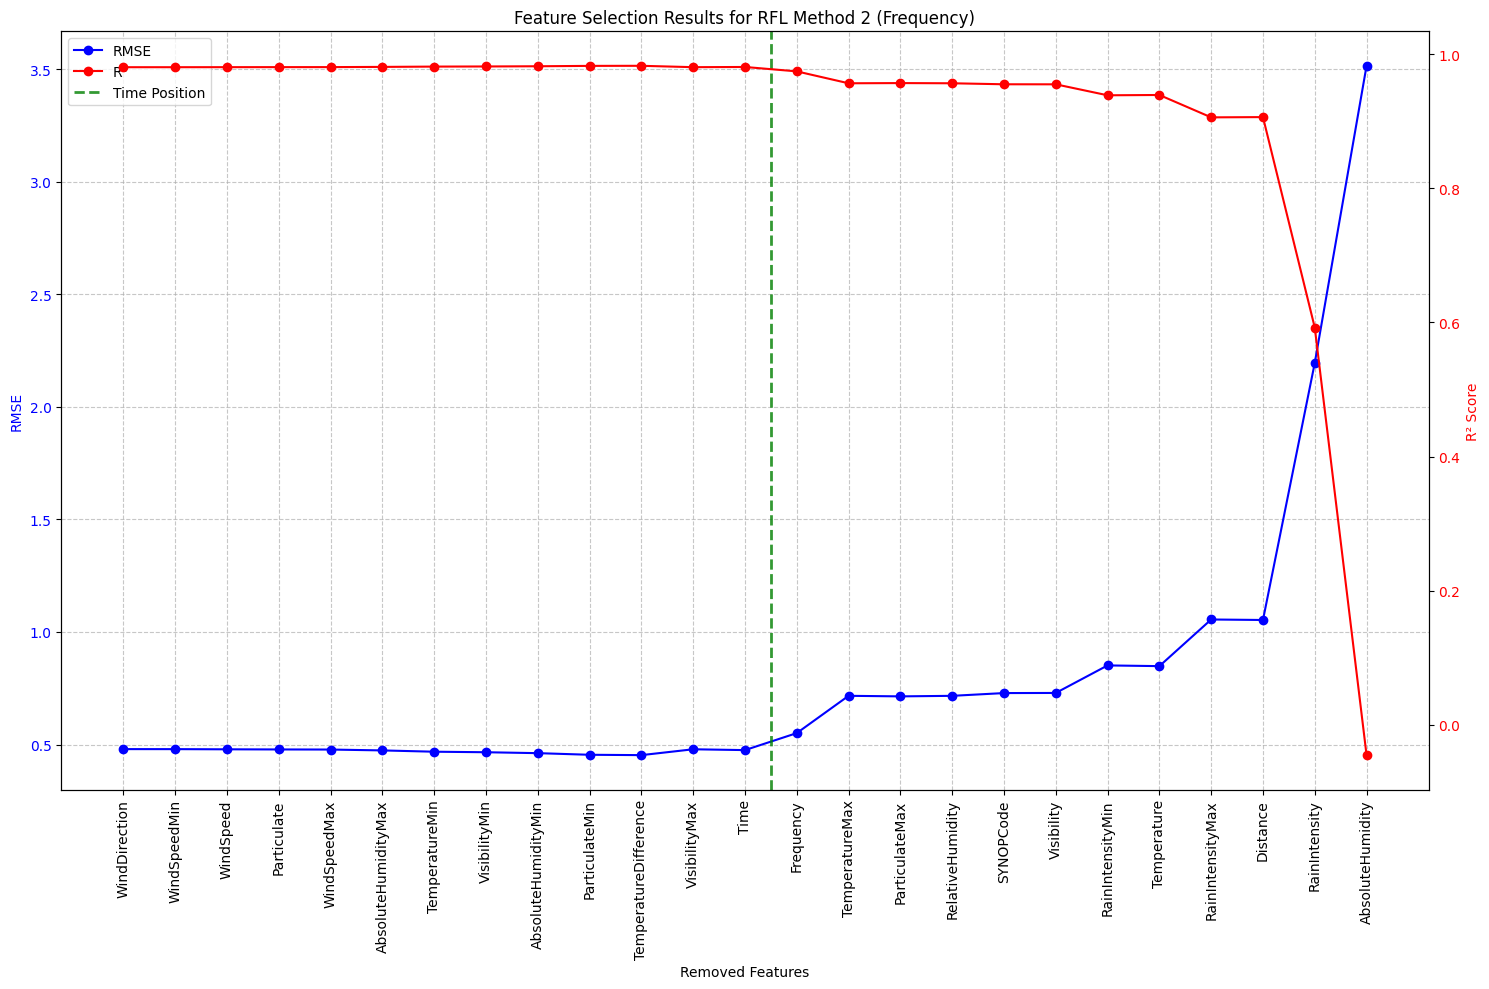

In [84]:
important_features_rfl_method2 = load_and_plot_method2_result('RFL', 'Frequency')


In [ ]:
important_features_rfl_method2

['AbsoluteHumidity',
 'Distance',
 'Frequency',
 'ParticulateMax',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'SYNOPCode',
 'Temperature',
 'TemperatureMax',
 'Visibility']

In [109]:

X_rfl_method2, y_rfl_method2 = gene_final_X_y(important_features_rfl_method2, 'RFL_Att')

start_time = time.time()

rfl_method2_tune = tune_random_forest(
    X_rfl_method2, 
    y_rfl_method2,
    cv=5,
    verbose=True
)

rfl_method2_best_model = rfl_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (91379, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.974337 |  0.974337 |  0.550888
         100 |        10 |  0.959332 |  0.959332 |  0.693487
         100 |        20 |  0.974234 |  0.974234 |  0.551998
         150 |      None |  0.974558 |  0.974558 |  0.548518
         150 |        10 |  0.959519 |  0.959519 |  0.691896
         150 |        20 |  0.974480 |  0.974480 |  0.549354

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.974558
Best OOB R² Score: 0.974558
Best OOB RMSE: 0.548518
Model training time: 55.96 seconds


In [115]:
# for compare, we need to get the metric of different SYNOP code

metric_rfl_method2_synop = []
for synop_code in [0, 3, 4, 5, 6, 7, 8]:
    X_rfl_method2_synop_code, y_rfl_method2_synop_code = gene_final_X_y(important_features_rfl_method2, 'RFL_Att', synop_code)
    # we should get the slice of these data, because we need to oob_score
    oob_pred = rfl_method2_best_model.oob_prediction_[X_rfl_method2_synop_code.index]
    r2 = r2_score(y_rfl_method2_synop_code, oob_pred)
    rmse = np.sqrt(mean_squared_error(y_rfl_method2_synop_code, oob_pred))
    metric_rfl_method2_synop.append({'synop_code': synop_code, 'r2': r2, 'rmse': rmse})

for item in metric_rfl_method2_synop:
    print(f"SYNOP Code: {item['synop_code']}, R² Score: {item['r2']:.6f}, RMSE: {item['rmse']:.6f}")



SYNOP Code: 0, R² Score: 0.970975, RMSE: 0.435509
SYNOP Code: 3, R² Score: 0.944889, RMSE: 0.704493
SYNOP Code: 4, R² Score: 0.955448, RMSE: 0.351736
SYNOP Code: 5, R² Score: 0.970571, RMSE: 0.494226
SYNOP Code: 6, R² Score: 0.966103, RMSE: 0.744139
SYNOP Code: 7, R² Score: 0.948715, RMSE: 0.347146
SYNOP Code: 8, R² Score: 0.937243, RMSE: 0.770711


## FSO



### Method 1

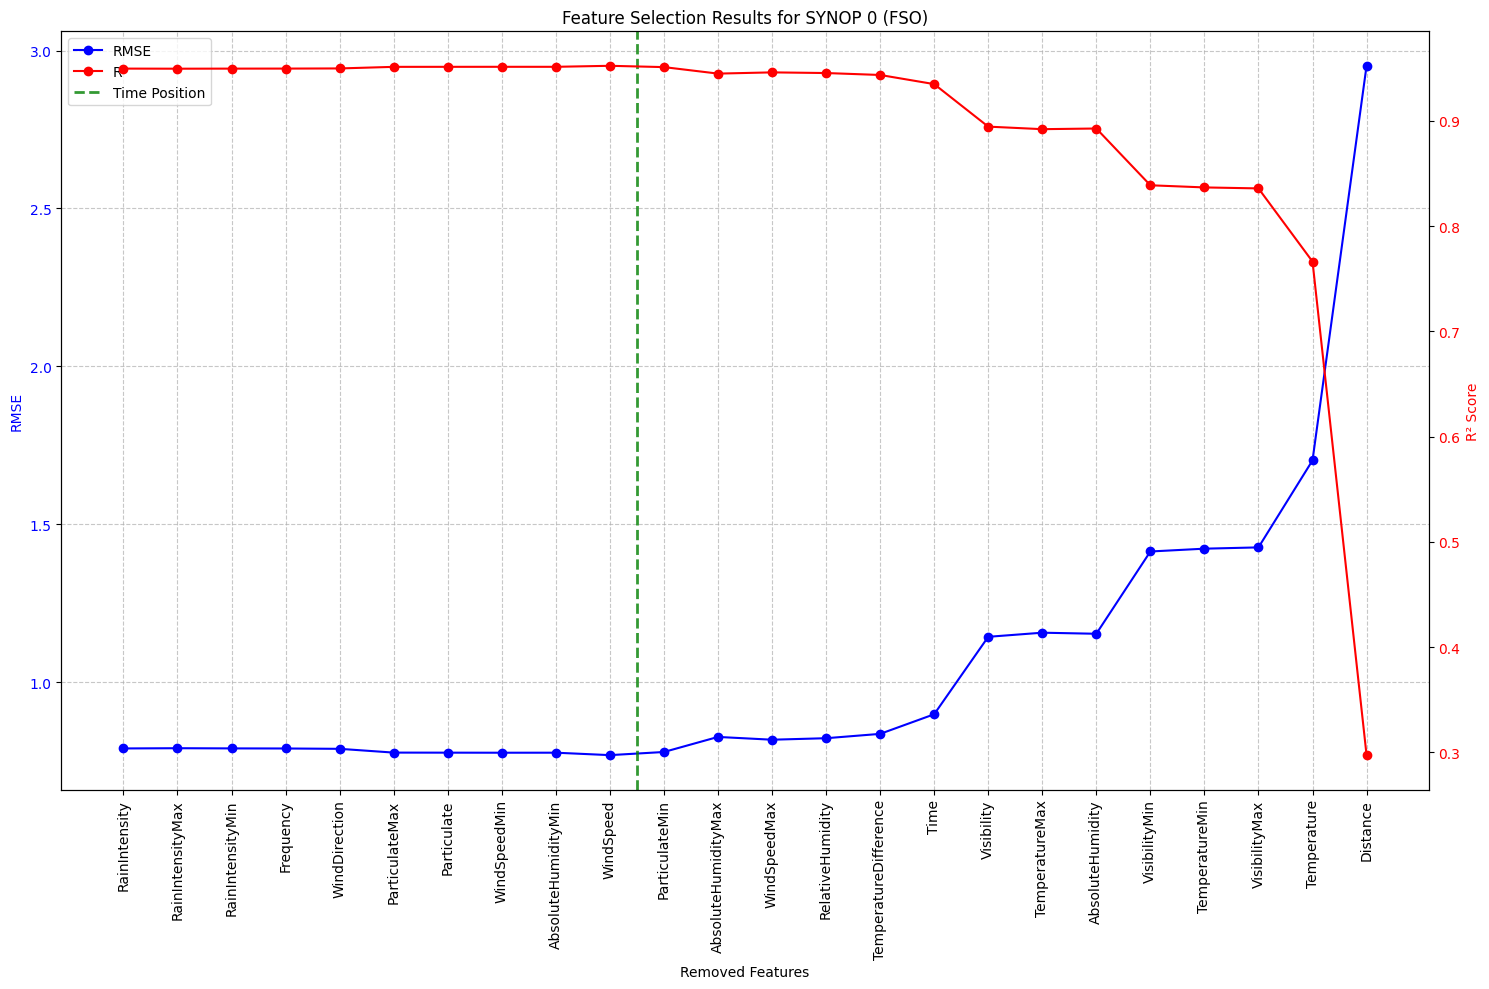

In [85]:
important_features_fso_method1_synop_0 = load_and_plot_single_result('FSO', 0, 'ParticulateMin')


In [30]:
important_features_fso_method1_synop_0

['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'Distance',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMax',
 'TemperatureMin',
 'Time',
 'Visibility',
 'VisibilityMax',
 'VisibilityMin',
 'WindSpeedMax']

In [94]:

X_fso_method1_synop_0, y_fso_method1_synop_0 = gene_final_X_y(important_features_fso_method1_synop_0, 'FSO_Att', 0)

start_time = time.time()

fso_method1_synop_0_tune = tune_random_forest(
    X_fso_method1_synop_0, 
    y_fso_method1_synop_0,
    cv=5,
    verbose=True
)

fso_method1_synop_0_best_model = fso_method1_synop_0_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (56964, 14)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.951048 |  0.951048 |  0.779050
         100 |        10 |  0.901774 |  0.901774 |  1.103560
         100 |        20 |  0.949290 |  0.949290 |  0.792917
         150 |      None |  0.951807 |  0.951807 |  0.772995
         150 |        10 |  0.902292 |  0.902292 |  1.100645
         150 |        20 |  0.950168 |  0.950168 |  0.786023

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.951807
Best OOB R² Score: 0.951807
Best OOB RMSE: 0.772995
Model training time: 48.13 seconds


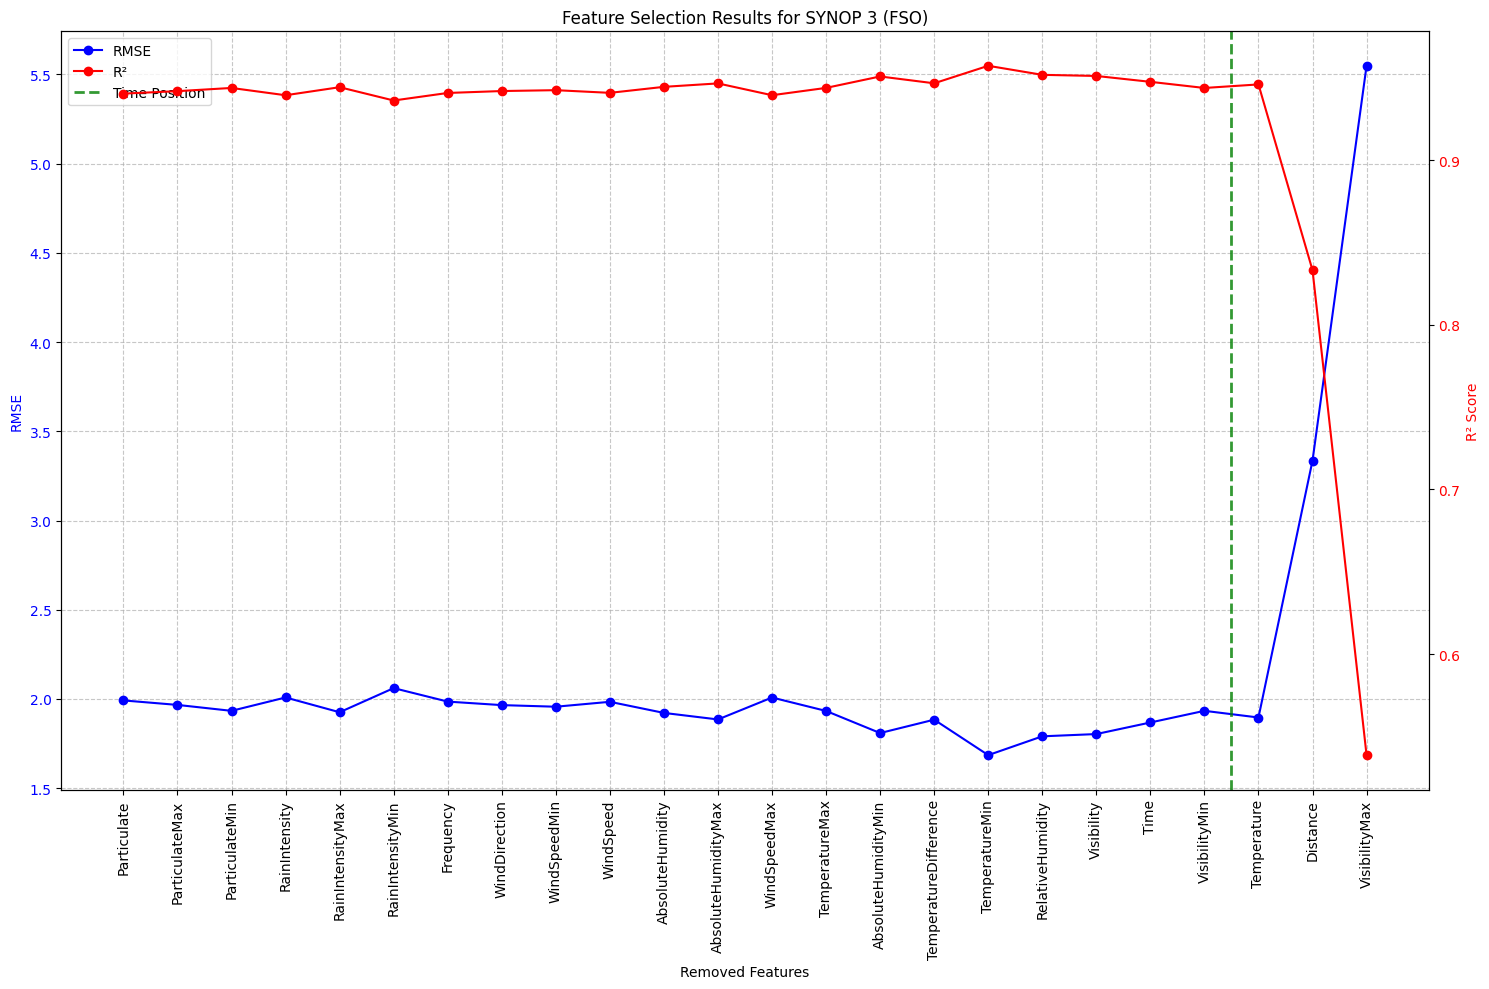

In [86]:
important_features_fso_method1_synop_3 = load_and_plot_single_result('FSO', 3, 'Temperature')


In [32]:
important_features_fso_method1_synop_3

['Distance', 'Temperature', 'VisibilityMax']

In [100]:

X_fso_method1_synop_3, y_fso_method1_synop_3 = gene_final_X_y(important_features_fso_method1_synop_3, 'FSO_Att', 3)

start_time = time.time()

fso_method1_synop_3_tune = tune_random_forest(
    X_fso_method1_synop_3, 
    y_fso_method1_synop_3,
    cv=5,
    verbose=True
)

fso_method1_synop_3_best_model = fso_method1_synop_3_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (191, 3)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.946115 |  0.946115 |  1.896081
         100 |        10 |  0.946570 |  0.946570 |  1.888058
         100 |        20 |  0.946115 |  0.946115 |  1.896081
         150 |      None |  0.946064 |  0.946064 |  1.896988
         150 |        10 |  0.946090 |  0.946090 |  1.896533
         150 |        20 |  0.946064 |  0.946064 |  1.896988

Best result:
Best parameters: n_estimators=100, max_depth=10
Best OOB Score: 0.946570
Best OOB R² Score: 0.946570
Best OOB RMSE: 1.888058
Model training time: 0.80 seconds


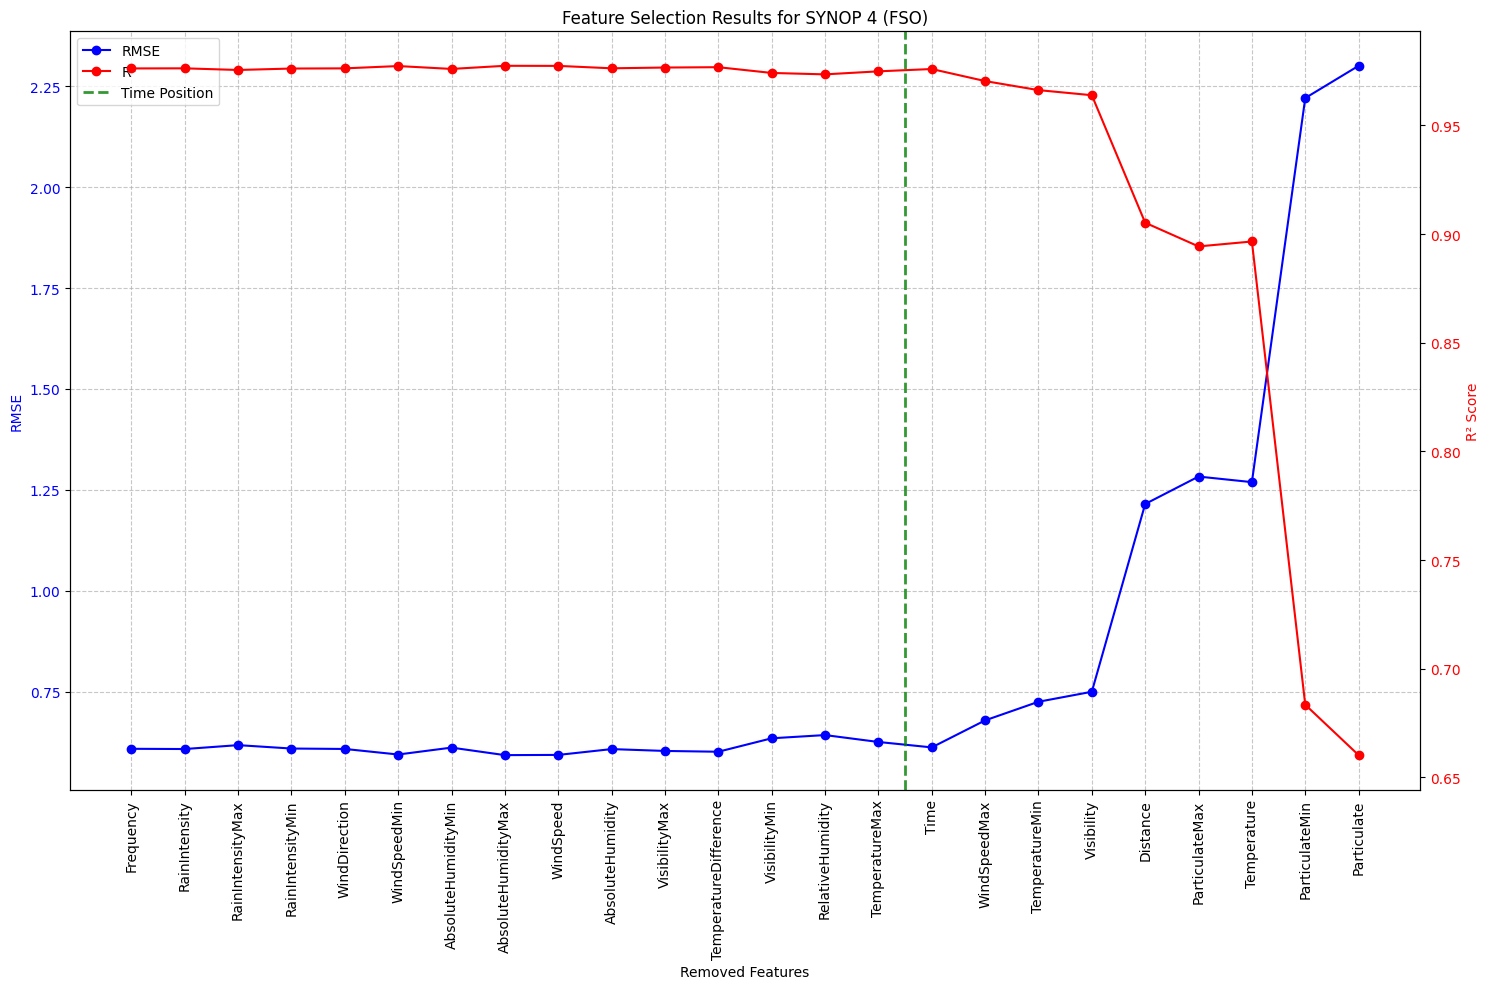

In [87]:
important_features_fso_method1_synop_4 = load_and_plot_single_result('FSO', 4, 'Time')


In [39]:
important_features_fso_method1_synop_4

['Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'Temperature',
 'TemperatureMin',
 'Time',
 'Visibility',
 'WindSpeedMax']

In [103]:

X_fso_method1_synop_4, y_fso_method1_synop_4 = gene_final_X_y(important_features_fso_method1_synop_4, 'FSO_Att', 4)

start_time = time.time()

fso_method1_synop_4_tune = tune_random_forest(
    X_fso_method1_synop_4, 
    y_fso_method1_synop_4,
    cv=5,
    verbose=True
)

fso_method1_synop_4_best_model = fso_method1_synop_4_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (466, 9)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.975941 |  0.975941 |  0.612159
         100 |        10 |  0.974756 |  0.974756 |  0.627051
         100 |        20 |  0.975998 |  0.975998 |  0.611436
         150 |      None |  0.976464 |  0.976464 |  0.605469
         150 |        10 |  0.974710 |  0.974710 |  0.627630
         150 |        20 |  0.976510 |  0.976510 |  0.604877

Best result:
Best parameters: n_estimators=150, max_depth=20
Best OOB Score: 0.976510
Best OOB R² Score: 0.976510
Best OOB RMSE: 0.604877
Model training time: 0.84 seconds


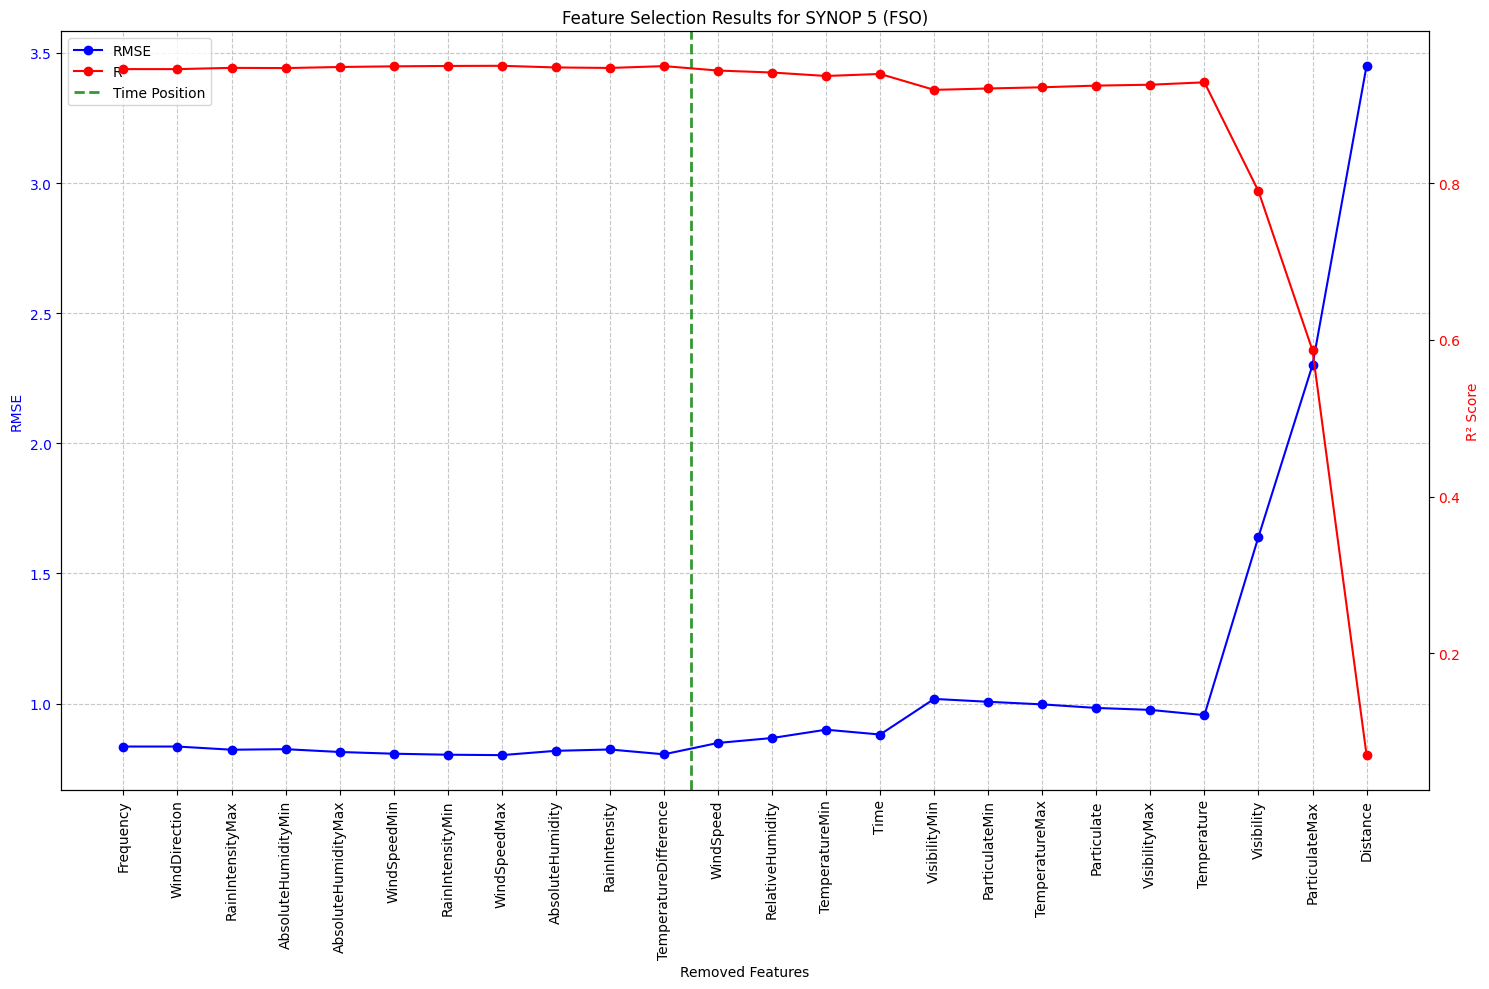

In [88]:
important_features_fso_method1_synop_5 = load_and_plot_single_result('FSO', 5, 'WindSpeed')


In [43]:
important_features_fso_method1_synop_5

['Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureMax',
 'TemperatureMin',
 'Time',
 'Visibility',
 'VisibilityMax',
 'VisibilityMin',
 'WindSpeed']

In [104]:

X_fso_method1_synop_5, y_fso_method1_synop_5 = gene_final_X_y(important_features_fso_method1_synop_5, 'FSO_Att', 5)

start_time = time.time()

fso_method1_synop_5_tune = tune_random_forest(
    X_fso_method1_synop_5, 
    y_fso_method1_synop_5,
    cv=5,
    verbose=True
)

fso_method1_synop_5_best_model = fso_method1_synop_5_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (6605, 13)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.943721 |  0.943721 |  0.848868
         100 |        10 |  0.923523 |  0.923523 |  0.989542
         100 |        20 |  0.943371 |  0.943371 |  0.851507
         150 |      None |  0.944785 |  0.944785 |  0.840809
         150 |        10 |  0.924226 |  0.924226 |  0.984983
         150 |        20 |  0.944488 |  0.944488 |  0.843065

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.944785
Best OOB R² Score: 0.944785
Best OOB RMSE: 0.840809
Model training time: 4.52 seconds


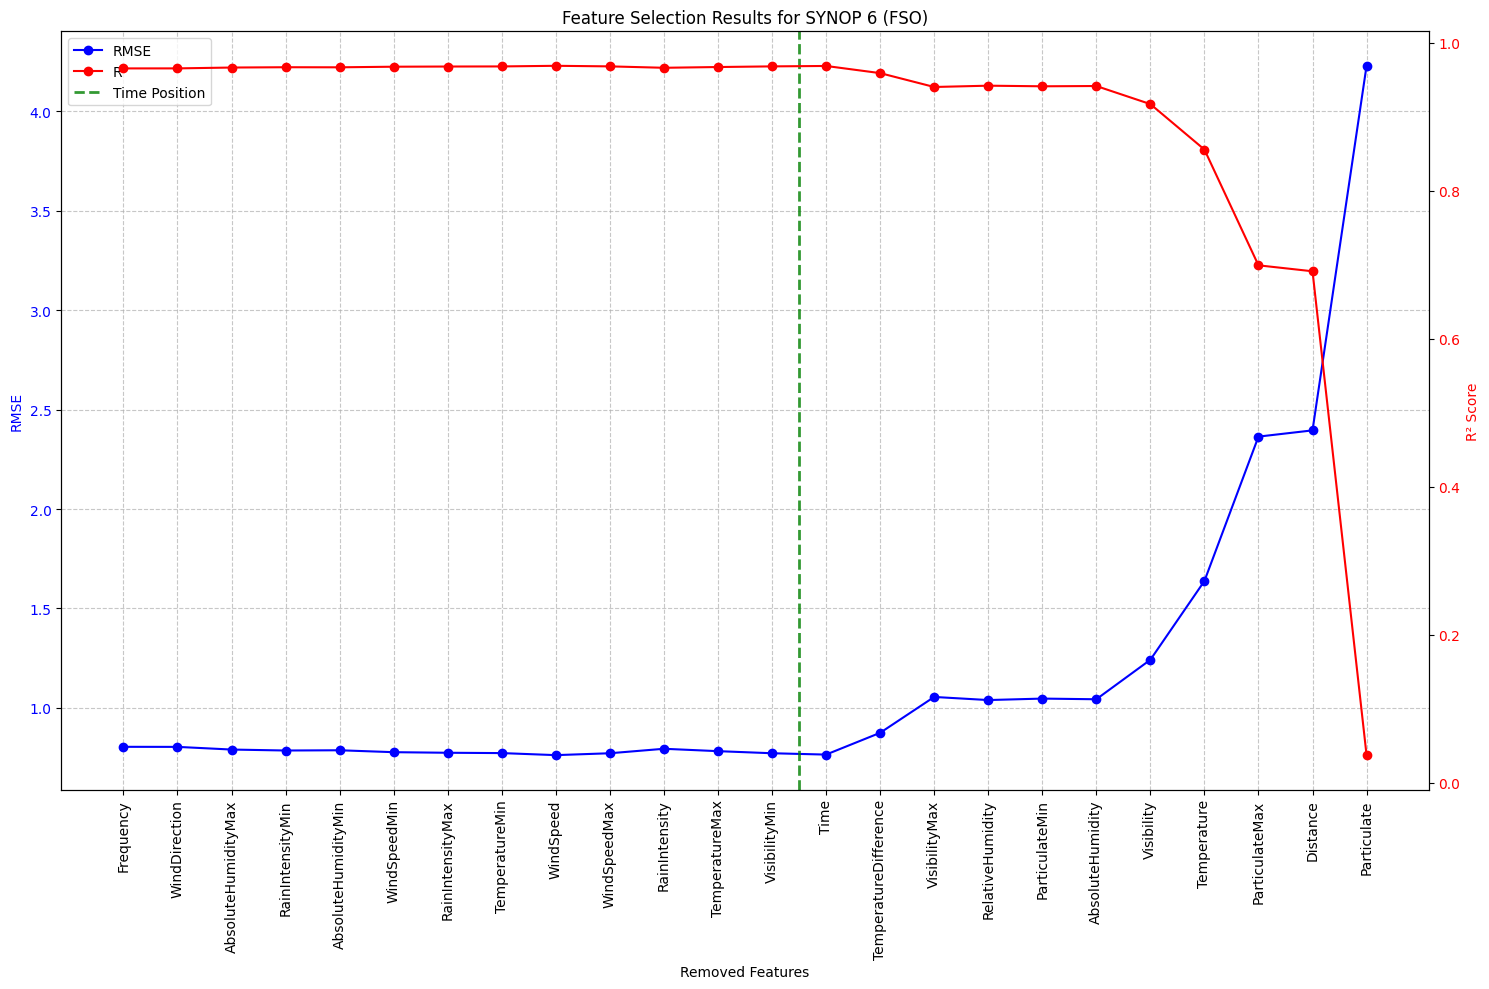

In [89]:
important_features_fso_method1_synop_6 = load_and_plot_single_result('FSO', 6, 'Time')


In [47]:
important_features_fso_method1_synop_6

['AbsoluteHumidity',
 'Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'Time',
 'Visibility',
 'VisibilityMax']

In [106]:

X_fso_method1_synop_6, y_fso_method1_synop_6 = gene_final_X_y(important_features_fso_method1_synop_6, 'FSO_Att', 6)

start_time = time.time()

fso_method1_synop_6_tune = tune_random_forest(
    X_fso_method1_synop_6, 
    y_fso_method1_synop_6,
    cv=5,
    verbose=True
)

fso_method1_synop_6_best_model = fso_method1_synop_6_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (25018, 11)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.968485 |  0.968485 |  0.765302
         100 |        10 |  0.928741 |  0.928741 |  1.150783
         100 |        20 |  0.968007 |  0.968007 |  0.771088
         150 |      None |  0.969372 |  0.969372 |  0.754453
         150 |        10 |  0.929527 |  0.929527 |  1.144422
         150 |        20 |  0.968963 |  0.968963 |  0.759477

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.969372
Best OOB R² Score: 0.969372
Best OOB RMSE: 0.754453
Model training time: 17.06 seconds


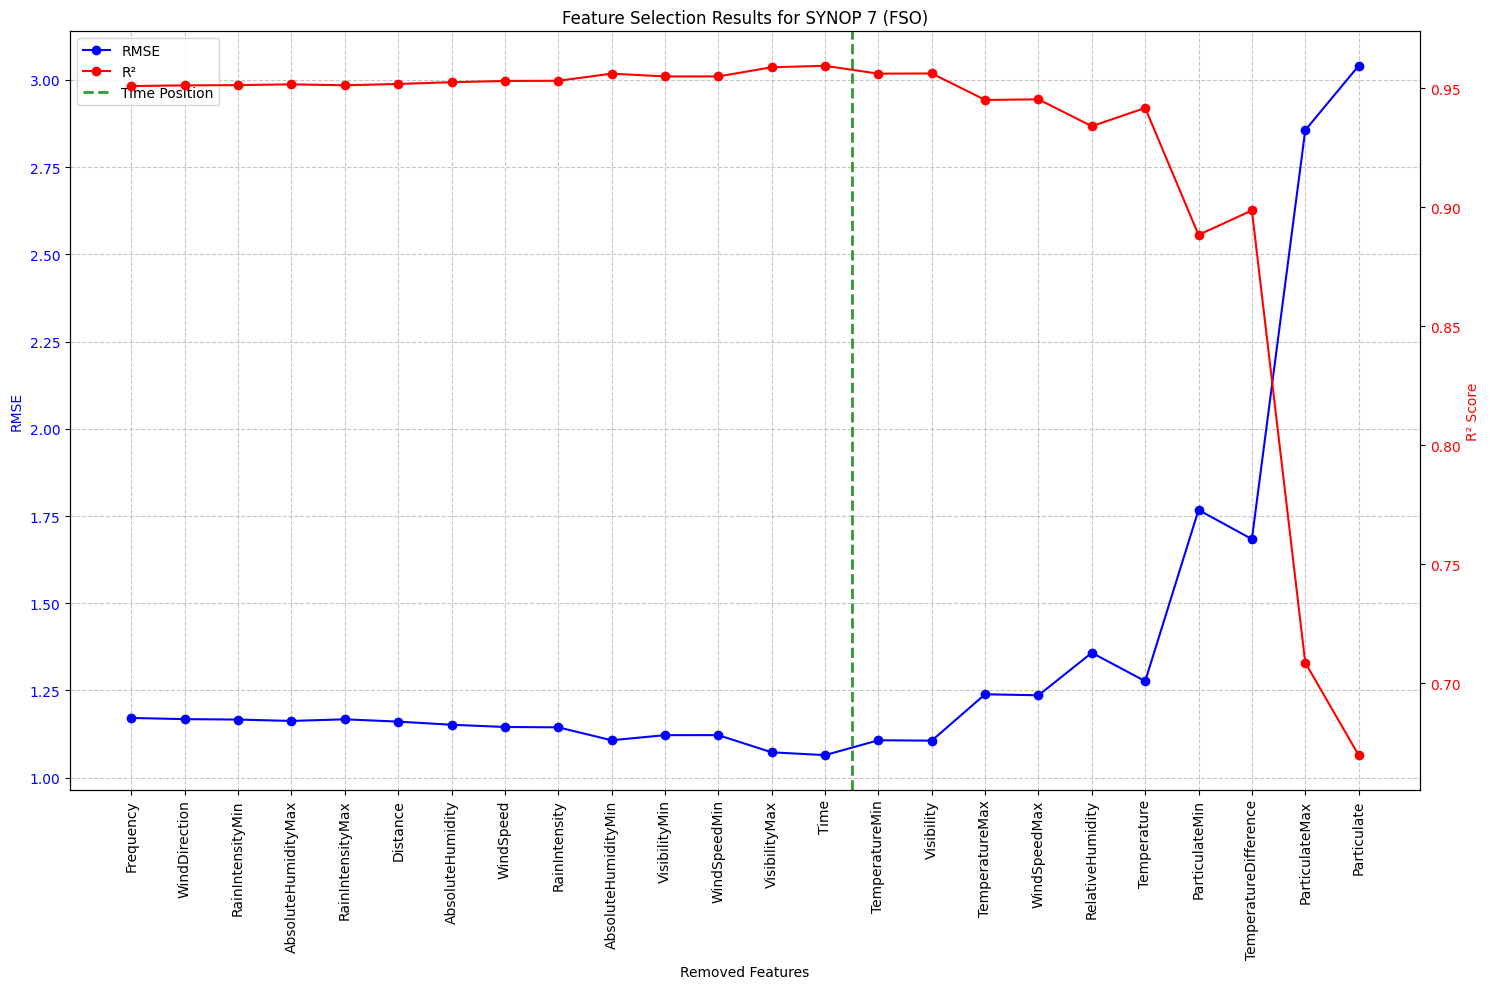

In [90]:
important_features_fso_method1_synop_7 = load_and_plot_single_result('FSO', 7, 'TemperatureMin')


In [51]:
important_features_fso_method1_synop_7

['Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMax',
 'TemperatureMin',
 'Visibility',
 'WindSpeedMax']

In [107]:

X_fso_method1_synop_7, y_fso_method1_synop_7 = gene_final_X_y(important_features_fso_method1_synop_7, 'FSO_Att', 7)

start_time = time.time()

fso_method1_synop_7_tune = tune_random_forest(
    X_fso_method1_synop_7, 
    y_fso_method1_synop_7,
    cv=5,
    verbose=True
)

fso_method1_synop_7_best_model = fso_method1_synop_7_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (419, 10)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.956189 |  0.956189 |  1.107331
         100 |        10 |  0.954832 |  0.954832 |  1.124358
         100 |        20 |  0.956208 |  0.956208 |  1.107088
         150 |      None |  0.959348 |  0.959348 |  1.066669
         150 |        10 |  0.958777 |  0.958777 |  1.074132
         150 |        20 |  0.959329 |  0.959329 |  1.066919

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.959348
Best OOB R² Score: 0.959348
Best OOB RMSE: 1.066669
Model training time: 0.85 seconds


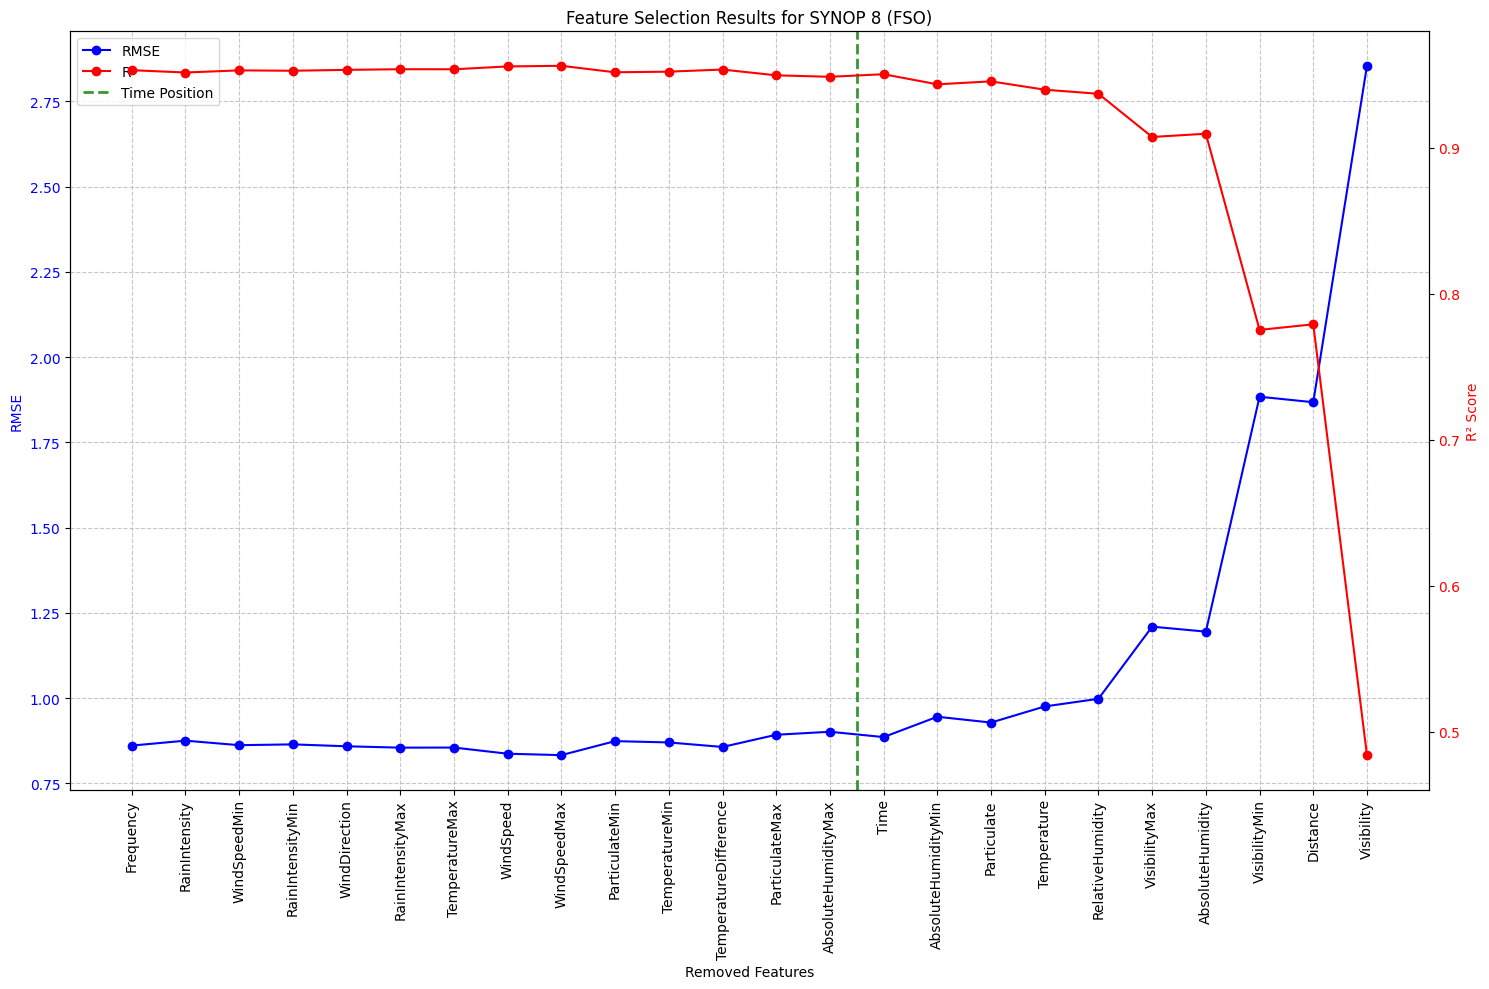

In [91]:
important_features_fso_method1_synop_8 = load_and_plot_single_result('FSO', 8, 'Time')


In [56]:
important_features_fso_method1_synop_8

['AbsoluteHumidity',
 'AbsoluteHumidityMin',
 'Distance',
 'Particulate',
 'RelativeHumidity',
 'Temperature',
 'Time',
 'Visibility',
 'VisibilityMax',
 'VisibilityMin']

In [108]:

X_fso_method1_synop_8, y_fso_method1_synop_8 = gene_final_X_y(important_features_fso_method1_synop_8, 'FSO_Att', 8)

start_time = time.time()

fso_method1_synop_8_tune = tune_random_forest(
    X_fso_method1_synop_8, 
    y_fso_method1_synop_8,
    cv=5,
    verbose=True
)

fso_method1_synop_8_best_model = fso_method1_synop_8_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (1716, 10)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.950269 |  0.950269 |  0.886052
         100 |        10 |  0.946000 |  0.946000 |  0.923297
         100 |        20 |  0.950066 |  0.950066 |  0.887860
         150 |      None |  0.950839 |  0.950839 |  0.880964
         150 |        10 |  0.946468 |  0.946468 |  0.919295
         150 |        20 |  0.950739 |  0.950739 |  0.881857

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.950839
Best OOB R² Score: 0.950839
Best OOB RMSE: 0.880964
Model training time: 1.21 seconds


### Method 2

In [14]:
X_fso_method2 = processed_data[feature_cols]
y_fso_method2 = processed_data['FSO_Att']

results_fso_method2 = feature_ranking_algorithm(X_fso_method2, y_fso_method2, n_jobs=-1)
# save results_rfl_method2 to pickle
with open('method2/results_fso_method2.pkl', 'wb') as f:
    pickle.dump(results_fso_method2, f)

1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25


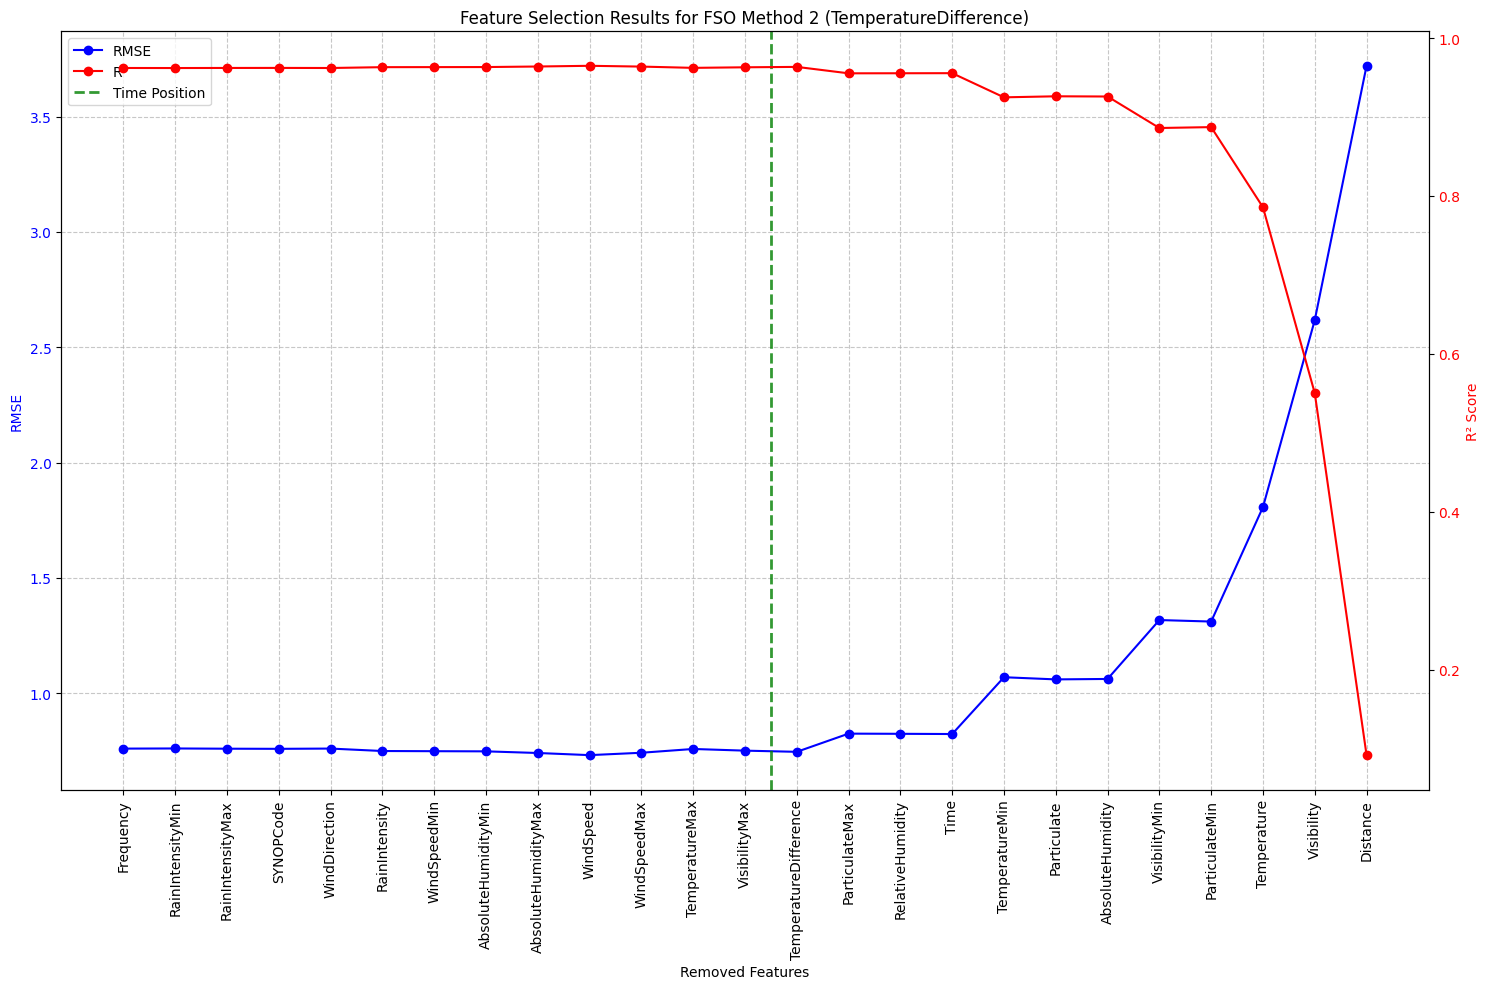

In [92]:
important_features_fso_method2 = load_and_plot_method2_result('FSO', 'TemperatureDifference')


In [25]:
important_features_fso_method2

['AbsoluteHumidity',
 'Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMin',
 'Time',
 'Visibility',
 'VisibilityMin']

In [110]:

X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso_method2, 'FSO_Att')

start_time = time.time()

fso_method2_tune = tune_random_forest(
    X_fso_method2, 
    y_fso_method2,
    cv=5,
    verbose=True
)

fso_method2_best_model = fso_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")



Start tuning...
Dataset size: (91379, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.963422 |  0.963422 |  0.746616
         100 |        10 |  0.907313 |  0.907313 |  1.188500
         100 |        20 |  0.961713 |  0.961713 |  0.763866
         150 |      None |  0.964192 |  0.964192 |  0.738718
         150 |        10 |  0.907597 |  0.907597 |  1.186680
         150 |        20 |  0.962374 |  0.962374 |  0.757243

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.964192
Best OOB R² Score: 0.964192
Best OOB RMSE: 0.738718
Model training time: 70.61 seconds


In [116]:
# for compare, we need to get the metric of different SYNOP code

metric_fso_method2_synop = []
for synop_code in [0, 3, 4, 5, 6, 7, 8]:
    X_fso_method2_synop_code, y_fso_method2_synop_code = gene_final_X_y(important_features_fso_method2, 'FSO_Att', synop_code)
    # we should get the slice of these data, because we need to oob_score
    oob_pred = fso_method2_best_model.oob_prediction_[X_fso_method2_synop_code.index]
    r2 = r2_score(y_fso_method2_synop_code, oob_pred)
    rmse = np.sqrt(mean_squared_error(y_fso_method2_synop_code, oob_pred))
    metric_fso_method2_synop.append({'synop_code': synop_code, 'r2': r2, 'rmse': rmse})

for item in metric_fso_method2_synop:
    print(f"SYNOP Code: {item['synop_code']}, R² Score: {item['r2']:.6f}, RMSE: {item['rmse']:.6f}")



SYNOP Code: 0, R² Score: 0.955570, RMSE: 0.742199
SYNOP Code: 3, R² Score: 0.981723, RMSE: 1.104282
SYNOP Code: 4, R² Score: 0.974542, RMSE: 0.629714
SYNOP Code: 5, R² Score: 0.964573, RMSE: 0.673495
SYNOP Code: 6, R² Score: 0.970897, RMSE: 0.735440
SYNOP Code: 7, R² Score: 0.964574, RMSE: 0.995739
SYNOP Code: 8, R² Score: 0.958434, RMSE: 0.810054


## Compare

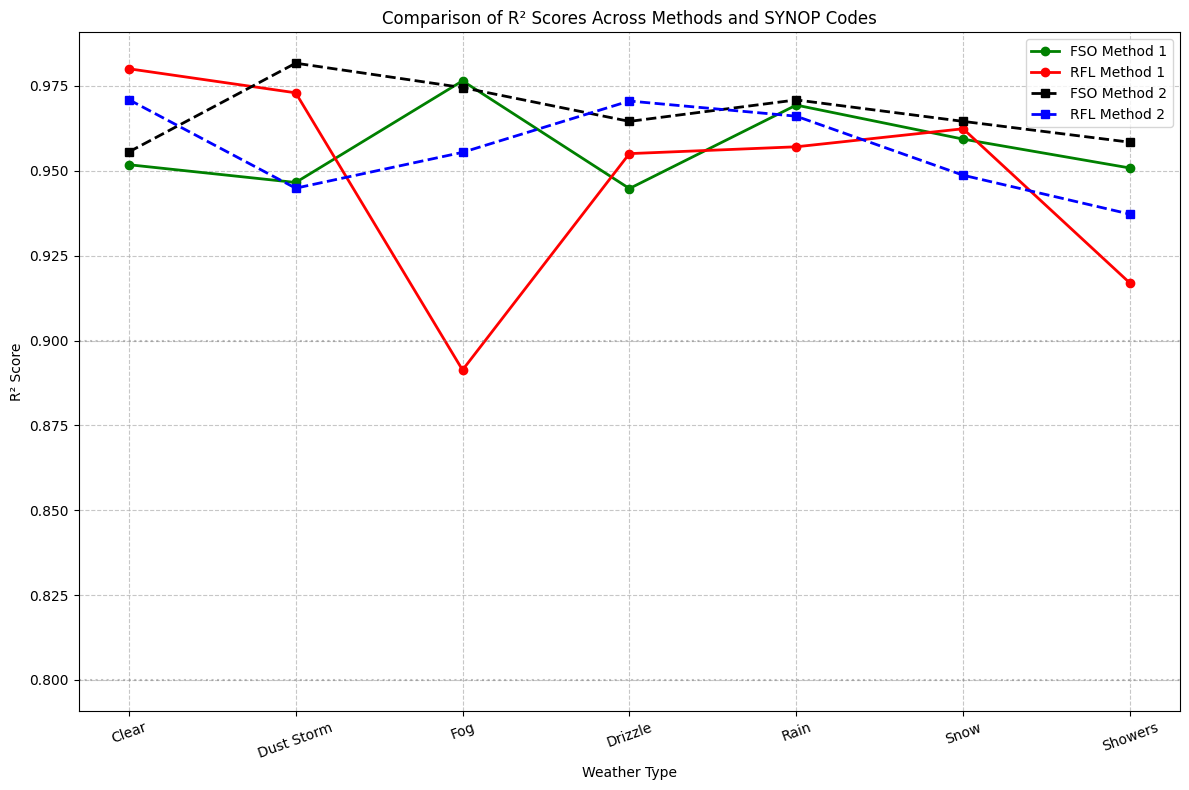

In [126]:
# collect the metrics in method 1
synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_types = ['Clear', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']
x_positions = range(len(weather_types))  # use continuous index [0, 1, 2, 3, 4, 5, 6]


# FSO Method 1 R2 scores
fso_method1_r2 = [
    fso_method1_synop_0_tune['oob_r2_score'],
    fso_method1_synop_3_tune['oob_r2_score'],
    fso_method1_synop_4_tune['oob_r2_score'],
    fso_method1_synop_5_tune['oob_r2_score'],
    fso_method1_synop_6_tune['oob_r2_score'],
    fso_method1_synop_7_tune['oob_r2_score'],
    fso_method1_synop_8_tune['oob_r2_score']
]

# RFL Method 1 R2 scores
rfl_method1_r2 = [
    rfl_method1_synop_0_tune['oob_r2_score'],
    rfl_method1_synop_3_tune['oob_r2_score'],
    rfl_method1_synop_4_tune['oob_r2_score'],
    rfl_method1_synop_5_tune['oob_r2_score'],
    rfl_method1_synop_6_tune['oob_r2_score'],
    rfl_method1_synop_7_tune['oob_r2_score'],
    rfl_method1_synop_8_tune['oob_r2_score']
]

# Method 2 data from the metrics we collected
fso_method2_r2 = [item['r2'] for item in metric_fso_method2_synop]
rfl_method2_r2 = [item['r2'] for item in metric_rfl_method2_synop]

plt.figure(figsize=(12, 8))

# Plot Method 1 lines
plt.plot(x_positions, fso_method1_r2, 'g-', linewidth=2, label='FSO Method 1', marker='o')
plt.plot(x_positions, rfl_method1_r2, 'r-', linewidth=2, label='RFL Method 1', marker='o')



# Plot Method 2 lines
plt.plot(x_positions, fso_method2_r2, 'k--', linewidth=2, label='FSO Method 2', marker='s')
plt.plot(x_positions, rfl_method2_r2, 'b--', linewidth=2, label='RFL Method 2', marker='s')

plt.xlabel('Weather Type')
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores Across Methods and SYNOP Codes')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Set x-axis ticks to show only the SYNOP codes
plt.xticks(x_positions, weather_types, rotation=20)


# Add horizontal lines at y=0.8 and y=0.9 for reference
plt.axhline(y=0.8, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

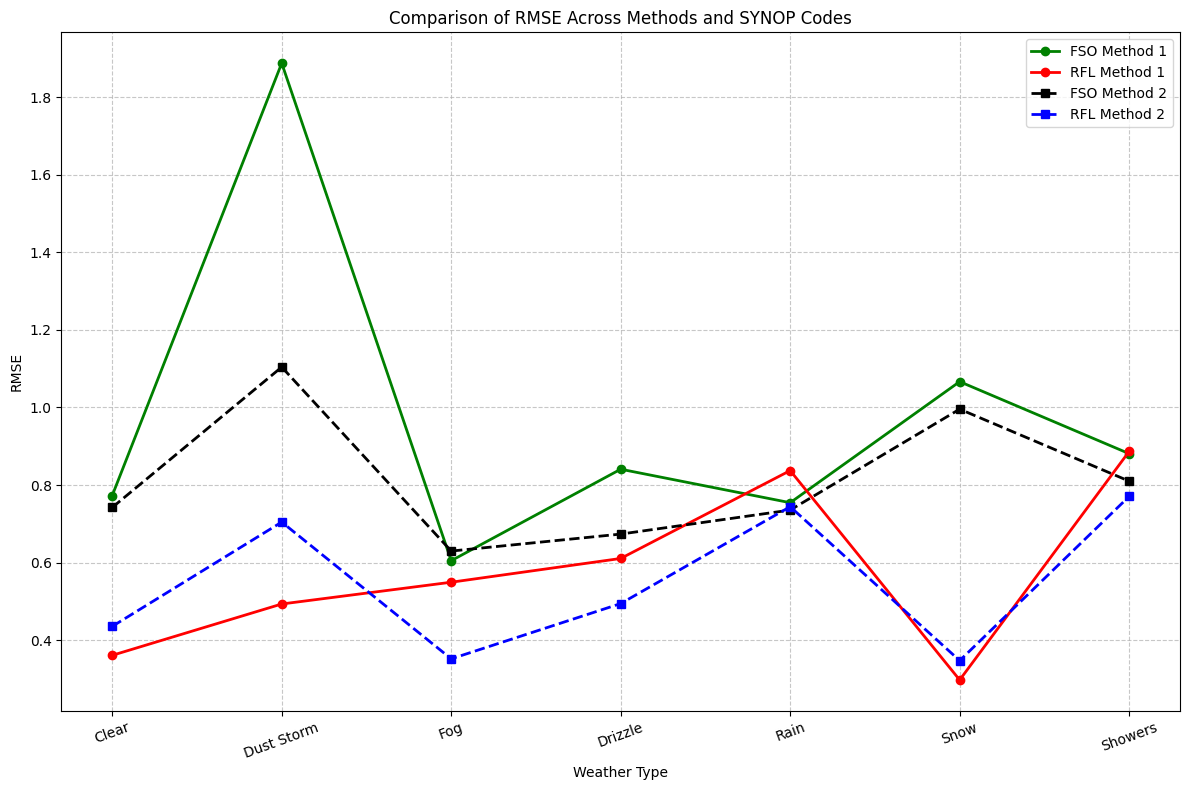

In [127]:
# collect the RMSE data
synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_types = ['Clear', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']
x_positions = range(len(weather_types))


# FSO Method 1 RMSE scores
fso_method1_rmse = [
    fso_method1_synop_0_tune['oob_rmse'],
    fso_method1_synop_3_tune['oob_rmse'],
    fso_method1_synop_4_tune['oob_rmse'],
    fso_method1_synop_5_tune['oob_rmse'],
    fso_method1_synop_6_tune['oob_rmse'],
    fso_method1_synop_7_tune['oob_rmse'],
    fso_method1_synop_8_tune['oob_rmse']
]

# RFL Method 1 RMSE scores
rfl_method1_rmse = [
    rfl_method1_synop_0_tune['oob_rmse'],
    rfl_method1_synop_3_tune['oob_rmse'],
    rfl_method1_synop_4_tune['oob_rmse'],
    rfl_method1_synop_5_tune['oob_rmse'],
    rfl_method1_synop_6_tune['oob_rmse'],
    rfl_method1_synop_7_tune['oob_rmse'],
    rfl_method1_synop_8_tune['oob_rmse']
]

fso_method2_rmse = [item['rmse'] for item in metric_fso_method2_synop]
rfl_method2_rmse = [item['rmse'] for item in metric_rfl_method2_synop]

plt.figure(figsize=(12, 8))

plt.plot(x_positions, fso_method1_rmse, 'g-', linewidth=2, label='FSO Method 1', marker='o')
plt.plot(x_positions, rfl_method1_rmse, 'r-', linewidth=2, label='RFL Method 1', marker='o')

plt.plot(x_positions, fso_method2_rmse, 'k--', linewidth=2, label='FSO Method 2', marker='s')
plt.plot(x_positions, rfl_method2_rmse, 'b--', linewidth=2, label='RFL Method 2', marker='s')

plt.xlabel('Weather Type')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Across Methods and SYNOP Codes')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.xticks(x_positions, weather_types, rotation=20)

plt.tight_layout()
plt.show()

In [139]:

index_names = [
    'FSO RMSE Improvement',
    'FSO RMSE Improvement (%)',
    'FSO R² Improvement',
    'FSO R² Improvement (%)',
    'RFL RMSE Improvement',
    'RFL RMSE Improvement (%)',
    'RFL R² Improvement',
    'RFL R² Improvement (%)'
]

data = {
    'Clear': [],
    'Dust Storm': [],
    'Fog': [],
    'Drizzle': [],
    'Rain': [],
    'Snow': [],
    'Showers': []
}

for i in range(len(weather_types)):
    data[weather_types[i]] = [
        # FSO RMSE
        fso_method2_rmse[i] - fso_method1_rmse[i],
        ((fso_method2_rmse[i] - fso_method1_rmse[i]) / fso_method2_rmse[i]) * 100,
        
        # FSO R²
        fso_method2_r2[i] - fso_method1_r2[i],
        ((fso_method2_r2[i] - fso_method1_r2[i]) / fso_method2_r2[i]) * 100,
        
        # RFL RMSE
        rfl_method2_rmse[i] - rfl_method1_rmse[i],
        ((rfl_method2_rmse[i] - rfl_method1_rmse[i]) / rfl_method2_rmse[i]) * 100,
        
        # RFL R²
        rfl_method2_r2[i] - rfl_method1_r2[i],
        ((rfl_method2_r2[i] - rfl_method1_r2[i]) / rfl_method2_r2[i]) * 100
    ]

df = pd.DataFrame(data, index=index_names)

for idx in df.index:
    if 'Improvement (%)' in idx:
        df.loc[idx] = df.loc[idx].map('{:.1f}%'.format)
    else:
        df.loc[idx] = df.loc[idx].map('{:.3f}'.format)

display(df)

Clear Dust Storm     Fog Drizzle    Rain    Snow  \
FSO RMSE Improvement      -0.031     -0.784   0.025  -0.167  -0.019  -0.071   
FSO RMSE Improvement (%)   -4.1%     -71.0%    3.9%  -24.8%   -2.6%   -7.1%   
FSO R² Improvement         0.004      0.035  -0.002   0.020   0.002   0.005   
FSO R² Improvement (%)      0.4%       3.6%   -0.2%    2.1%    0.2%    0.5%   
RFL RMSE Improvement       0.075      0.211  -0.198  -0.116  -0.093   0.050   
RFL RMSE Improvement (%)   17.2%      30.0%  -56.2%  -23.6%  -12.5%   14.4%   
RFL R² Improvement        -0.009     -0.028   0.064   0.015   0.009  -0.014   
RFL R² Improvement (%)     -0.9%      -3.0%    6.7%    1.6%    0.9%   -1.4%   

                         Showers  
FSO RMSE Improvement      -0.071  
FSO RMSE Improvement (%)   -8.8%  
FSO R² Improvement         0.008  
FSO R² Improvement (%)      0.8%  
RFL RMSE Improvement      -0.116  
RFL RMSE Improvement (%)  -15.0%  
RFL R² Improvement         0.020  
RFL R² Improvement (%)      2.2%